# FINAL REPORT

Course: Applied Parallel Programming

18127039 -  Lâm Ngọc Phương Anh

18127046 - Lư Ngọc Liên 

1653098 - Võ Minh Tú


# Enhancing Document Image

## I.Phát biểu bài toán




### 1.Tổng quan


Enhacing document image là một bước trong công việc xử lý ảnh, là bước nền cơ bản hỗ trợ cho các chức năng nâng cao khác như scan hình ảnh, chuyển đổi ảnh thành text, điều chỉnh lại góc chụp của bức ảnh.

Một vài ứng dụng sử dụng bài toán này là:
- Chức năng scan ảnh trong ứng dụng Note của Iphone
- CamScanner

### 2.Mô tả đầu ra và đầu vào của bài toán






* Đầu vào: một bức ảnh có góc chụp không trực diện với màn hình
* Đầu ra: Bức ảnh có góc chụp trực diện với màn hình (bỏ đi các background dư thừa)

![](https://i.imgur.com/8cfHARR.png)

*cre*: [dropbox.Tech, Jongmin Baek, Aug 16, 2016, Fast document rectification and enhancement](https://dropbox.tech/machine-learning/fast-document-rectification-and-enhancement)

### **3.Các bước thực hiện**
* Phát hiện biên cạnh
* Lấy viền của đối tượng dựa trên các cạnh đã xác định
* Đưa ảnh tài liệu về đối diện màn hình
* Điều chỉnh độ tương phản, độ sáng của bức ảnh

#### Bước 1: Phát hiện biên cạnh

https://minhng.info/tutorials/xu-ly-anh-opencv-hien-thuc-canny-edge.html

* Phát hiện biên cạnh là bước tìm ra các biên thuộc các đối tượng trong ảnh, nhầm phân tách và biết được hình dạng (shape) các đối tượng đó.
* Có 2 thuật toán nổi tiếng cho bài toán này là Sobel edge detector và Canny edge detector.
* Trong bài toán này nhóm xin chọn sử dụng thuật toán Canny edge detector. Thuật toán gồm 4 bước
    1. Giảm nhiễu: tiến hành làm mờ và giảm nhiễu cho bức ảnh bằng Gaussian ([Công thức của Gaussian Filter](https://docs.opencv.org/2.4/doc/tutorials/imgproc/gausian_median_blur_bilateral_filter/gausian_median_blur_bilateral_filter.html#gaussian-filter))
    2. Tình Gradient và hướng gradient: Sử dụng bộ lọc Sobel X và Sobel Y để lấy ra được đạo hàm theo chiều ngang (Gx) và dọc của bức ảnh (Gy). Từ đó ta sẽ tính được  gradient (độ lớn của sự biến đổi mức sáng ở vị trí pixel tương ứng với ảnh gốc) và hướng của từng pixel trong ảnh theo công thức sau. Trong đó hướng của cạnh được chia thành 4 hướng đại diện: ngang (0 độ), chéo bên phải (45 độ), dọc (90 độ), chéo bên trái (135 độ). 
  $$Edge\_Gradient(G) = \sqrt{G^2_x + G^2_y}$$

  $$Angle (Θ) = tan^{-1} (\frac{G_y}{G_x})$$
  3. Tính non-max suppression: Mục đích lọc bỏ các pixel không phải là cực đại cục bộ. Ta sử dụng 1 filter 3x3 chạy lần lượt qua các pixel của ảnh sau khi đã gradient. Trong các lần chạy, ta xét độ lớn của pixel hiện tại có phải là cực đại so với 2 hàng xóm (dựa trên hướng gradient)  hay không. Nếu là cực đại thì ghi nhận lại pixel đó, ngược lại set độ lớn của pixel đó bằng 0.
  4. Lọc ngưỡng: ở đây ta có 2 giá trị được gọi là maxVal và minVal. Nếu pixel hiện tại có giá trị lớn hơn maxVal thì pixel đó là cạnh, nhỏ hơn minVal thì bị loại bỏ. Còn các pixel nằm giữa maxVal và minVal, ta sẽ xét nó nằm gần với bên nào để quyết định có giữ lại nó hay không. 



* **Có nên tăng tốc giai đoạn xử lý ảnh này không? Tại sao? Và nếu cần tăng tốc thì có thể áp dụng lập trình song song vào không?**
    * **Nên** Thời gian để nhân tích chấp có thể khá lâu nếu bức ảnh có kích thước lớn. 
    * Có thể áp dụng lập trình song song vào ở các bước 1 và bước tính gradient của bước 2 vì các pixel sẽ được tính toán một cách độc lập.

#### Bước 2: Lấy viền của đối tượng dựa trên các cạnh đã xác định

* Mục tiêu của bước này này là lấy ra được viền của ảnh đã lấy biên, các pixel của ảnh lúc này chỉ là 0 hoặc 255. Sử dụng hàm OpenCV cho bước này vì nhóm không tìm được thuật toán tham khảo để có thể thực hiện cài đặt tuần tự và đưa ra đánh giá. Giá trị trả ra của hàm là toàn bộ các viền có trong ảnh, các viền ở đây là tập hợp các pixel có giá trị 255 và liền kề nhau.

#### Bước 3: Đưa ảnh tài liệu về đối diện màn hình


* Lúc này, ta sẽ lấy các pixel nằm bên trong viền đã được nhận diện ở bước trước đó, thực hiện việc map các điểm ảnh này sang một không gian tọa độ mới (đối diện màn hình).

* Các hướng tiếp cận cho bước có điểm chung là đều được thực hiện bằng cách nhân ma trận trên một hệ tọa độ đồng nhất ([Homogeneous coordinates](https://en.wikipedia.org/wiki/Homogeneous_coordinates)):

    * Sử dụng các **phép xoay ảnh**: Xoay bức ảnh quanh một điểm theo một góc xác định nào đó, vẫn giữ nguyên các tính chất của ảnh (các góc của ảnh vẫn giữ nguyên).
    * Sử dụng phép biến đổi affine: Cần xác định ba điểm trên ảnh gốc và vị trí của chúng trên ảnh kết quả. Biến đổi affine giúp tạo ra nhiều tư thế, biến thể khác nhau của vật thể. Các biến thể này sẽ được bảo toàn tính song song, tỉ lệ khoảng cách của vật thể và các đường thẳng trong ảnh.
    * Sử dụng biến đổi phối cảnh (Perspective transform hoặc Homography transform): Đây là một phép biến đổi đặc biệt khi mà ảnh kết quả không được đảm bảo về góc, độ dài, tính song song so với ảnh gốc ngoại trừ bảo toàn đường thẳng.


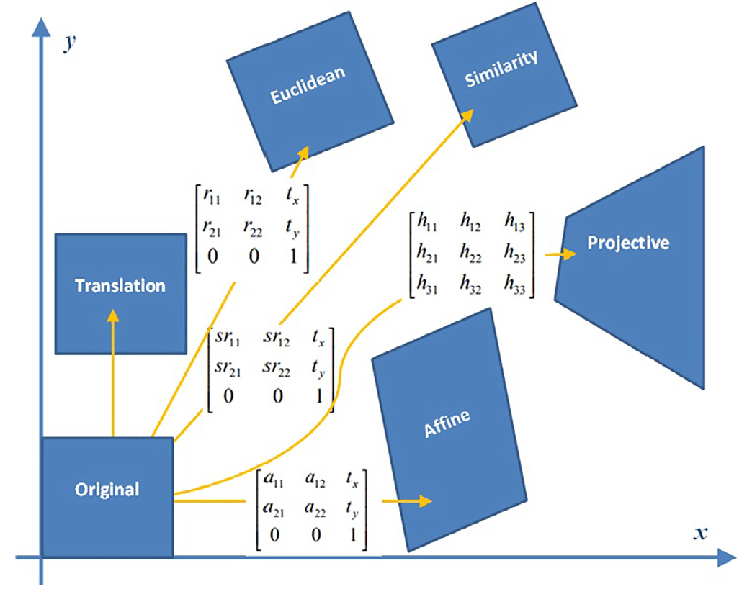

cre: A. Soycan - Metin Soycan (2018), Perspective correction of building facade images for architectural applications. Engineering Science and Technology an International Journal 22(3).

##### **Phép biến đổi Homography**

* Đối với bài toán này, hình dạng của văn bản trong ảnh đầu vào đa dạng và không phải luôn là chữ nhật $→$ **biến đổi phối cảnh** sẽ là giải pháp tốt nhất để có thể đưa văn bản về đối diện màn hình.

* Các bước thực hiện phép biến đổi Homography:
    
    3.1. Xác định 4 điểm góc của văn bản trong ảnh đầu vào (source points) và xem nó là 4 đỉnh của ảnh đầu ra (target points).
    
    3.2. Dựa trên 4 điểm đã chọn, tính chiều dài và rộng cho ảnh đầu ra $→$ xác định được tọa độ 4 đỉnh trong không gian mới và kích thước của ảnh output.
    
    3.3. Khi đã có được source và target points thì ta có thể dễ dàng tính được ma trận biến đổi **H** (3x3).
    
    3.4. Thực hiện việc chuyển đổi tọa độ cho từng điểm ảnh bằng công thức sau:
    $$dst(x,y) = src(\frac{H_{0,0}x + H_{0,1}y + H_{0,2}}{H_{2,0}x + H_{2,1}y + H_{2,2}},\frac{H_{1,0}x + H_{1,1}y + H_{1,2}}{H_{2,0}x + H_{2,1}y + H_{2,2}})$$ 


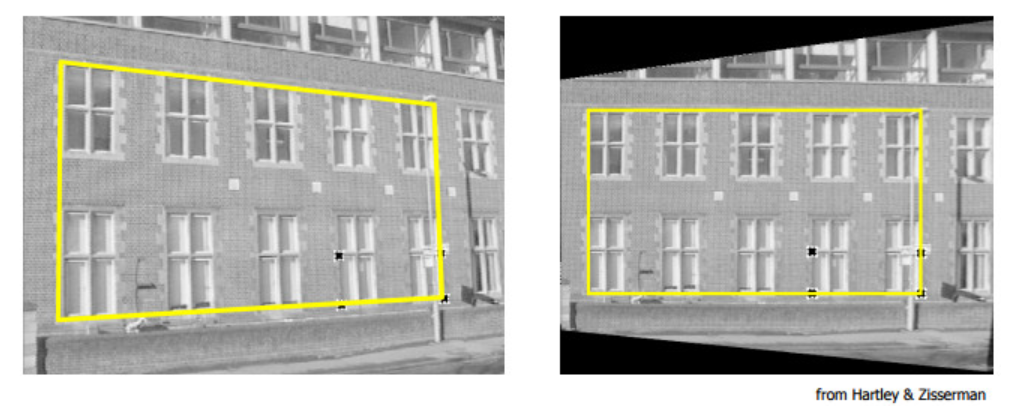

cre: [OpenCV, Basic concepts of the homography explained with code.](https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html)

* **Có nên tăng tốc giai đoạn xử lý ảnh này không? Tại sao? Và nếu cần tăng tốc thì có thể áp dụng lập trình song song vào không?**
    * **Nên** vì có thể thấy tại bước 4 của quá trình này là việc xác định tọa độ mới của từng pixel, điều này có thể sẽ tốn nhiều thời gian khi kích thước bức ảnh lớn.
    * Có thể áp dụng lập trình song song vào **bước 3.4** vì các pixel sẽ được tính toán một cách độc lập.

#### Bước 4: Điều chỉnh độ tương phản, độ sáng của bức ảnh

* Điều chỉnh độ sáng, độ tương phản của bức ảnh sau khi đã đưa ảnh tài liệu về chính diện màn hình.
* Trong GIMP, mức độ tương phản đi từ -127 đến +127


* Bước đầu tiên là tính toán hệ số hiệu chỉnh độ tương phản được đưa ra bởi công thức sau:

>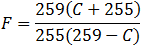

* Để thuật toán hoạt động chính xác, giá trị của hệ số hiệu chỉnh độ tương phản ( F ) cần được lưu trữ dưới dạng số dấu phẩy động chứ không phải số nguyên. Giá trị C trong công thức biểu thị mức độ tương phản mong muốn.

* Bước tiếp theo là tự thực hiện điều chỉnh độ tương phản thực tế. Công thức sau đây cho thấy sự điều chỉnh độ tương phản được thực hiện đối với thành phần màu đỏ của một màu:

>image.png

* Ta sẽ điều chỉnh công thức lại để phù hợp:

>f = 131 * (tương phản + 127) / (127 * (131-tương phản))

>new_image = f * (old_image - 127) + 127 = f * (old_image) + 127 * (1-f)

* Tiếp theo ta sẽ tìm ra độ sáng

* Đầu tiên, hãy tính toán giá trị hiệu chỉnh gamma để sử dụng cho việc điều chỉnh âm trung (nếu muốn). Phần sau mô phỏng gần đúng kỹ thuật của Photoshop, áp dụng gamma 9.99-1.00 cho các giá trị midtone 0-128 và 1.00-0.01 cho 128-255.

**Apply gamma correction:**

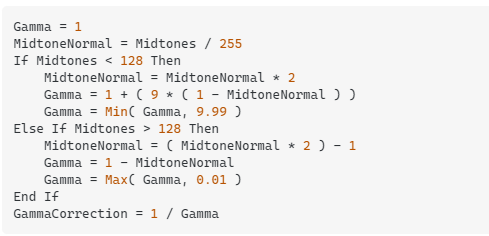


* Sau đó, đối với mỗi giá trị kênh R, G, B (0-255) cho mỗi pixel, hãy thực hiện theo thứ tự sau.

**Apply the input levels:**

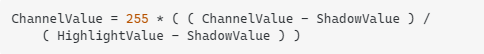

**Apply the midtones:**

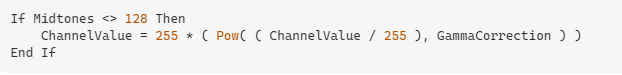

**Apply the output levels:**

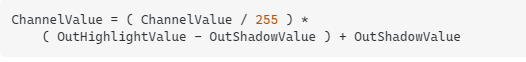

**Where:**

* Tất cả các giá trị kênh và thông số điều chỉnh là số nguyên, bao gồm 0-255
* Shadow / Midtone / HighlightValue là các giá trị điều chỉnh đầu vào (mặc định 0, 128, 255)
* OutShadow / HighlightValue là các giá trị điều chỉnh đầu ra (mặc định là 0, 255)
* Ta sẽ tối ưu hóa mọi thứ và đảm bảo các giá trị được giữ trong giới hạn (chẳng hạn như 0-255 cho mỗi kênh)
* Để mô phỏng Photoshop chính xác hơn, bạn có thể sử dụng đường cong nội suy phi tuyến tính nếu Midtones <128. Theo mặc định, Photoshop cũng cắt bỏ 0,1% giá trị tối nhất và sáng nhất.





















* **Có nên tăng tốc giai đoạn xử lý ảnh này không? Tại sao? Và nếu cần tăng tốc thì có thể áp dụng lập trình song song vào không?**
    * **Không nên** vì không mất quá nhiều thơi gian khi chỉnh sửa độ sáng cũng như độ tương phản theo công thức trên.

### 4.Khai báo thư viện + đọc ảnh đầu vào

Các phần sử dụng hàm của OpenCV :
-  [Canny edge detection](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123?fbclid=IwAR0e9rtoffrqAwTEx9bc8TzpX3y0bgx3UcDRkJR_njyENCY8heaObum6Nks)

- [Find coutours](https://stackoverflow.com/questions/62039403/python-opencv-finding-the-biggest-contour)

- [Homography](https://pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/)

In [1]:
import numpy as np
from numba import *
from PIL import *
import requests
from io import BytesIO
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
import math
import time
from numba import jit, cuda

from itertools import permutations
import pandas as pd

from skimage.filters import threshold_local

# from google.colab.patches import cv2_imshow
# import imutils

import warnings
warnings.filterwarnings('ignore')

In [2]:
# img_path = 'kid.png'
img_path = '../input/image-test/kid.png'
# img_path = '../input/appdataset/kid.png'
img = np.asarray(Image.open(img_path))

## II.Tuần tự

### 1.Các hàm xử lý ảnh được viết

#### a.Hàm làm xám ảnh

In [3]:
@jit(cache=True)
def convert_RGB_Gray_py(img):
    gray = np.zeros((img.shape[0],img.shape[1]), img.dtype)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            gray[i,j] = round(img[i,j,0] * 0.2989  + img[i,j,1] * 0.5870 + img[i,j,2] * 0.1141, 0)
    
    return gray

#### b.Hàm tính tích chập

In [4]:
@jit(cache=True)
def convolutionLayer_py(img, kernel):
    img_out = np.zeros(img.shape)
    rows, cols = img.shape
    rows_k, cols_k = kernel.shape
    for r in range(rows):
        for c in range(cols):
            out = 0
            for r_k in range(rows_k):
                for c_k in range(cols_k):
                    in_r = r - rows_k//2 + r_k;
                    in_c = c - cols_k//2 + c_k;
                    in_r = min(max(0, in_r), rows - 1);
                    in_c = min(max(0, in_c), cols - 1);
                    out += kernel[r_k,c_k] * img[in_r,in_c];
            img_out[r,c] = round(out)
    return img_out

#### c.Hàm tính element-wise cho ma trận

In [5]:
@jit(cache = True)
def edgeSobel_py(mat1, mat2):
    out_mat = np.zeros(mat1.shape)
    for i in range(mat1.shape[0]):
        for j in range(mat1.shape[1]):
            out_mat[i, j] = (mat1[i, j]**2 + mat2[i, j]**2)**0.5
    return out_mat

@jit(cache = True)
def angleGrad_py(mat1, mat2):
    out_mat = np.zeros(mat1.shape)
    for i in range(mat1.shape[0]):
        for j in range(mat1.shape[1]):
            out_mat[i, j] =  math.atan2(mat2[i,j], mat1[i,j]) * (180/np.pi)
            if out_mat[i, j] < 0:
                out_mat[i, j] += 180
    return out_mat

#### d.Gaussian kernel và Sobel kernel

In [6]:
gau_kernel_size = 3
gau_kernel = cv2.getGaussianKernel(gau_kernel_size**2,1)
gau_kernel = gau_kernel.reshape((gau_kernel_size,gau_kernel_size))

In [7]:
sobel_x_kernel, sobel_y_kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], np.float32), np.array([[1,2,1],[0,0,0],[-1,-2,-1]], np.float32)

#### e.Hàm tính edge gradient

In [8]:
def edgeGradient_cv(img):
    sobel_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize = 3, borderType=cv2.BORDER_REPLICATE)
    sobel_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize = 3, borderType=cv2.BORDER_REPLICATE)
    edge_sobel = np.hypot(sobel_x, sobel_y)
    
    #convert radian value to degree
    angle = np.arctan2(sobel_y, sobel_x) * 180 / np.pi
    angle[angle<0] += 180
        
    return edge_sobel, angle

@jit(cache=True)
def edgeGradient_py(img, sobel_x_kernel, sobel_y_kernel):
    sobel_x = convolutionLayer_py(img,sobel_x_kernel)
    sobel_y = convolutionLayer_py(img,sobel_y_kernel)
    
    edge_sobel = edgeSobel_py(sobel_x, sobel_y)
    
    #convert radian value to degree
    angle = angleGrad_py(sobel_x, sobel_y)
                    
    return edge_sobel, angle

#### f.Hàm xác định non max suppression

In [9]:
@jit(cache=True)
def nonMaxSuppression(img, angle):
    Z = np.zeros(img.shape, np.int32)

    for r in range(1, img.shape[0]-1):
        for c in range(1, img.shape[1]-1):
            q, t = 255, 255
            
            if 0 <= angle[r,c] < 22.5 or 180 >= angle[r,c] >= 157.5:
                q, t = img[r, c+1], img[r, c-1]
            elif 67.5 > angle[r,c] >= 22.5:
                q, t = img[r+1, c-1], img[r-1, c+1]
            elif 112.5 > angle[r,c] >= 67.5:
                q, t = img[r+1, c], img[r-1, c]
            elif 157.5 > angle[r,c] >= 112.5:
                q, t = img[r-1, c-1], img[r+1, c+1]
            
            if img[r,c] >=q and img[r,c] >=t:
                Z[r,c] = img[r,c]
            else:
                Z[r,c] = 0
    return Z

#### g.Hàm lọc ngưỡng

In [10]:
@jit(cache=True)
def hysteresisThreshold(img, min_thres, max_thres):

    canny_mask = np.zeros(img.shape, np.int32)
    max_val = img.max() * max_thres
    min_val = max_val * min_thres
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y,x] > max_val:
                canny_mask[y,x] = 255
            elif img[y,x] > min_val:
                is_edge = False
                for i in range(max(0, y-1), min(img.shape[0], y+2)):
                    for j in range(max(0, x-1), min(img.shape[1], x+2)):
                        if img[i,j] > max_val:
                            is_edge = True
                            canny_mask[y,x] = 255
                            break
                    if is_edge:
                        break
    return canny_mask

#### h.Hàm xác định 4 góc
* Chọn ra các điểm phù hợp làm góc dựa trên các mảng chứa các điểm tọa độ cực

In [11]:
def get_pos (lst_can, min, max, pos = 0):
    if len(lst_can[(lst_can[:,pos] == min) | (lst_can[:,pos] == max)]) == 0:
        ans1 = lst_can[lst_can[:,pos] == lst_can[:,pos].max()]
        return ans1[0], -1
    else:
        if  len(lst_can[(lst_can[:,pos] == min) | (lst_can[:,pos] == max)]) == 2:
            ans1 = lst_can[(lst_can[:,pos] == min)]
            ans2 = lst_can[(lst_can[:,pos] == max)]
            return ans1[0], ans2[0]
        else:
            if  len(lst_can[(lst_can[:,pos] == max)]) == 1:
                ans2 = lst_can[(lst_can[:,pos] == max)]
                return ans2[0], -1
            else:
                ans2 = lst_can[(lst_can[:,pos] == min)]
                return ans2[0], -1

* **get_points**: từ kết quả của hàm get_pos, ta có thể có các giá trị -1 -> hàm này sẽ lọc ra và chỉ giữ những giá trị là các tọa độ.
* **get_4_vertices**: lọc mảng các tọa độ, lấy ra các giá trị độc nhất -> đây sẽ là 4 góc của ảnh.

In [12]:
def get_points(xy, lst):
    if xy[1] == -1:
        lst.append(xy[0])
    else:
        lst.extend(xy)

def get_4_vertices(t, l, r, b, lst_v):
    lst = []

    get_points(list(t), lst)
    get_points(list(l), lst)
    get_points(list(r), lst)
    get_points(list(b), lst)

    for i in range(len(lst)):
        flag = False
        for j in range(len(lst_v)):
            comp = lst[i] == lst_v[j]
            if comp.any():
                flag = True
        if not flag:
            lst_v.append(lst[i])

* **get_t_b**: sắp xếp các tọa độ lại theo vị trí top hoặc bottom
* **order_points_py**, **order_points_np**: sắp xếp lại thứ tự của các góc theo thứ tự: top-left, bottom-left, bottom-right, top-right

In [13]:
def order_points_np(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def order_points_py(pts, max_x, max_y, min_x, min_y):
    lst = [i for i in range(len(pts))]
    pts_permutations = set(permutations(lst))
    for i in pts_permutations:
        t1, t2, s1, s2 = pts[i[0]], pts[i[1]], pts[i[2]], pts[i[3]]
        A = np.array([[t1[0], 1], 
                    [t2[0], 1]])
        y = np.array([t1[1], t2[1]])

        x1 = np.linalg.solve(A, y)

        A = np.array([[s1[0], 1], 
                    [s2[0], 1]])
        y = np.array([s1[1], s2[1]])

        x2 = np.linalg.solve(A, y)

        x  = (x2[1] - x1[1]) / (x1[0] - x2[0])
        x = x if min_x < x < max_x else -1

        y = x1[0] * x + x1[1]
        y = y if min_y < y < max_y else -1

        if x != -1 and y != -1:
            return np.array([t1, s1, t2, s2]) #tl, tr, br, bl


#### i.Hàm xác định các tọa độ mới cho ảnh

In [14]:
def four_point_transform(image, pts):
    rect = order_points_np(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

@jit(cache = True)
def map_pos_homo(img, new_i, H):
    new_img = new_i.copy()
    for r in range(new_img.shape[0]):
        for c in range(new_img.shape[1]):
            x = (H[0,0] * c + H[0,1] * r + H[0,2]) / (H[2,0] * c + H[2,1] * r + H[2,2])
            y = (H[1,0] * c + H[1,1] * r + H[1,2]) / (H[2,0] * c + H[2,1] * r + H[2,2])
            x = int(x) + 1 if (x*100) % 100 >= 50 else int(x)
            y = int(y) + 1 if (y*100) % 100 >= 50 else int(y)
            if 0 <= y < img.shape[0] and 0 <= x < img.shape[1]:
                new_img[r, c] = img[y, x]
    return new_img

#### j.Hàm điều chỉnh độ sáng, độ tương phản

In [15]:
def controller(img, brightness=255, contrast=127):
	brightness = int((brightness - 0) * (255 - (-255)) / (510 - 0) + (-255))
	contrast = int((contrast - 0) * (127 - (-127)) / (254 - 0) + (-127))
	if brightness != 0:
		if brightness > 0:
			shadow = brightness
			max = 255
		else:
			shadow = 0
			max = 255 + brightness

		al_pha = (max - shadow) / 255
		ga_mma = shadow

		# The function addWeighted calculates
		# the weighted sum of two arrays
		cal = cv2.addWeighted(img, al_pha,img, 0, ga_mma)
	else:
		cal = img

	if contrast != 0:
		Alpha = float(131 * (contrast + 127)) / (127 * (131 - contrast))
		Gamma = 127 * (1 - Alpha)

		# The function addWeighted calculates
		# the weighted sum of two arrays
		cal = cv2.addWeighted(cal, Alpha,cal, 0, Gamma)
	return cal

#### k.Hàm xoay, lật ảnh

In [16]:
@jit(cache=True)
def flipImg_py(img, axis = 1): #1: y, 0: x
    new_img = np.zeros(img.shape, img.dtype)
    if axis == 1:
        for i in range(img.shape[0]):
            for j in range(img.shape[1] - 1, -1, -1):
                new_img[i, img.shape[1] - 1 - j] = img[i,j]
    else:
        for i in range(img.shape[0] - 1, -1, -1):
            for j in range(img.shape[1]):
                new_img[img.shape[0] - 1 - i, j] = img[i,j]
        
    return new_img

@jit(cache=True)
def rotImg_py(img, r = True):
    new_img = np.zeros((img.shape[1], img.shape[0], img.shape[2]), img.dtype)
    if r:
        for c in range(img.shape[1]):
            for r in range(img.shape[0]-1, -1, -1):
                new_img[c, img.shape[0] - 1 - r] = img[r, c]
    else:
        for r in range(img.shape[0]):
            for c in range(img.shape[1]-1, -1, -1):
                new_img[img.shape[1] - 1 - c, r] = img[r, c] 
    return new_img

### 2.Thực thi bằng OpenCV

#### Step 1

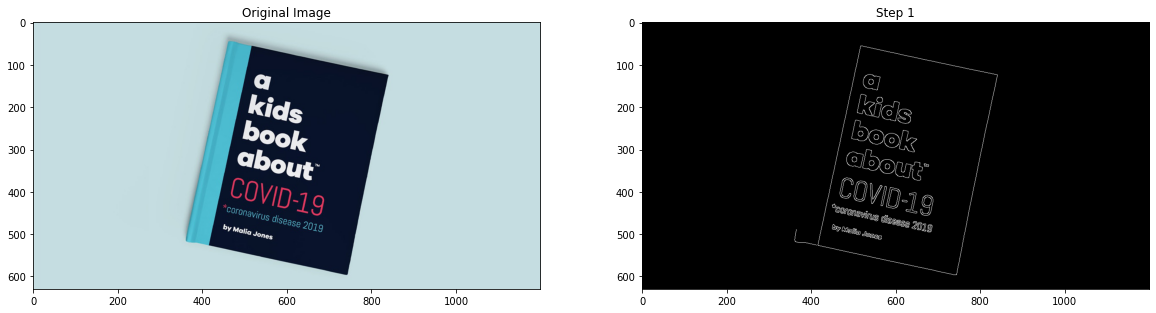

In [17]:
s = time.time()
gray_cv = cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2GRAY)
gaussianBlur_cv = cv2.GaussianBlur(gray_cv,(gau_kernel_size, gau_kernel_size),1, borderType = cv2.BORDER_REPLICATE)
canny_edge_cv = cv2.Canny(gaussianBlur_cv, 100, 200)
time_s1_cv = time.time() - s

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(img);
axis[0].set_title('Original Image');
axis[1].imshow(canny_edge_cv,cmap = 'gray');
axis[1].set_title('Step 1');

#### Step 2

In [18]:
def step2_host(img):
    cnts_jit, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts_jit = sorted(cnts_jit, key = lambda x: cv2.arcLength(x,True), reverse = True)
    choosen_cnt = cnts_jit[0].squeeze()

    max_x, max_y = choosen_cnt[:,0].max(),choosen_cnt[:,1].max()
    min_x, min_y = choosen_cnt[:,0].min(), choosen_cnt[:,1].min()

    b_can, t_can = choosen_cnt[choosen_cnt[:,0] == max_x], choosen_cnt[choosen_cnt[:,0] == min_x]
    l_can, r_can = choosen_cnt[choosen_cnt[:,1] == min_y], choosen_cnt[choosen_cnt[:,1] == max_y]

    t, b = get_pos(t_can, min_y, max_y, 1), get_pos(b_can, min_y, max_y, 1)
    l, r = get_pos(l_can, min_x, max_x, 0), get_pos(r_can, min_x, max_x, 0)

    four_vertices_cnts_jit = []

    get_4_vertices(t, l, r, b, four_vertices_cnts_jit)
    four_vertices_cnts_jit = order_points_py(four_vertices_cnts_jit, max_x, max_y, min_x, min_y)

    tl, tr, br, bl = four_vertices_cnts_jit
    widthA = ((br[0] - bl[0]) ** 2 + (br[1] - bl[1]) ** 2) ** 0.5
    widthB = ((tr[0] - tl[0]) ** 2 + (tr[1] - tl[1]) ** 2) ** 0.5

    maxWidth = int(widthA) if int(widthA) > int(widthB) else int(widthB)

    heightA = ((tr[0] - br[0]) ** 2 + (tr[1] - br[1]) ** 2) ** 0.5
    heightB = ((tl[0] - bl[0]) ** 2 + (tl[1] - bl[1]) ** 2) ** 0.5

    maxHeight = int(heightA) if int(heightA) > int(heightB) else int(heightB)

    n_four_vertices_cnts_jit = [n_tl, n_tr, n_br, n_bl] = np.array([[0,0], 
                                                    [0, maxWidth-1], 
                                                    [maxHeight-1, maxWidth - 1], 
                                                    [maxHeight - 1, 0]], dtype = 'float32')

    H = np.linalg.inv(cv2.getPerspectiveTransform(four_vertices_cnts_jit.astype('float32'), n_four_vertices_cnts_jit))
    return H, maxWidth, maxHeight, four_vertices_cnts_jit

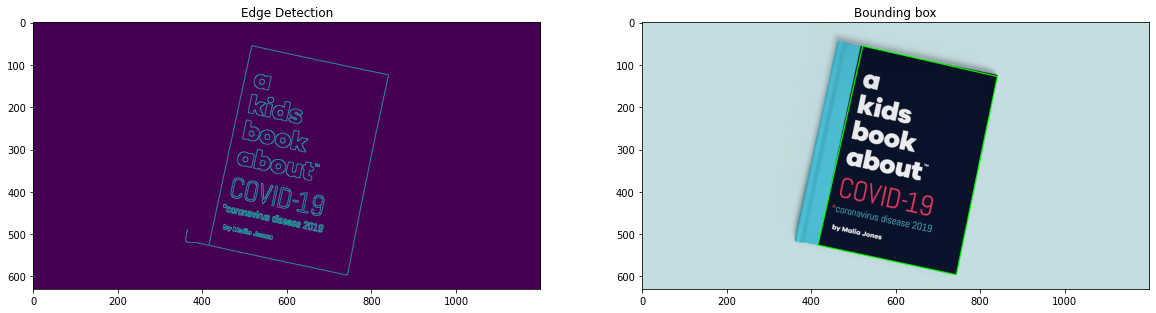

In [19]:
output_4_points_cv = img.copy()

s = time.time()
H, maxWidth, maxHeight, four_vertices_cnts_cv = step2_host(canny_edge_cv)
time_s2_cv = time.time() - s

cv2.drawContours(output_4_points_cv, [four_vertices_cnts_cv], 0, (0, 255, 0), 2)

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(canny_edge_cv);
axis[0].set_title('Edge Detection');
axis[1].imshow(output_4_points_cv);
axis[1].set_title('Bounding box');

#### Step 3

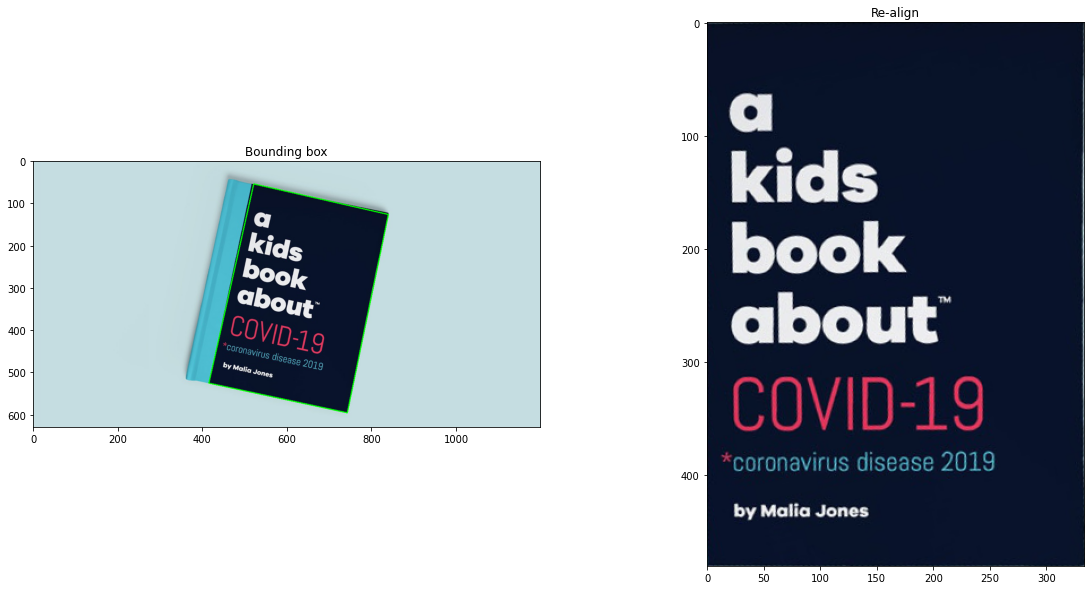

In [20]:
s = time.time()
homo_img_cv = four_point_transform(img, four_vertices_cnts_cv)
time_s3_cv = time.time() - s

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(output_4_points_cv);
axis[0].set_title('Bounding box');
axis[1].imshow(homo_img_cv);
axis[1].set_title('Re-align');

#### Step 4

##### Điều chỉnh độ sáng, độ tương phản

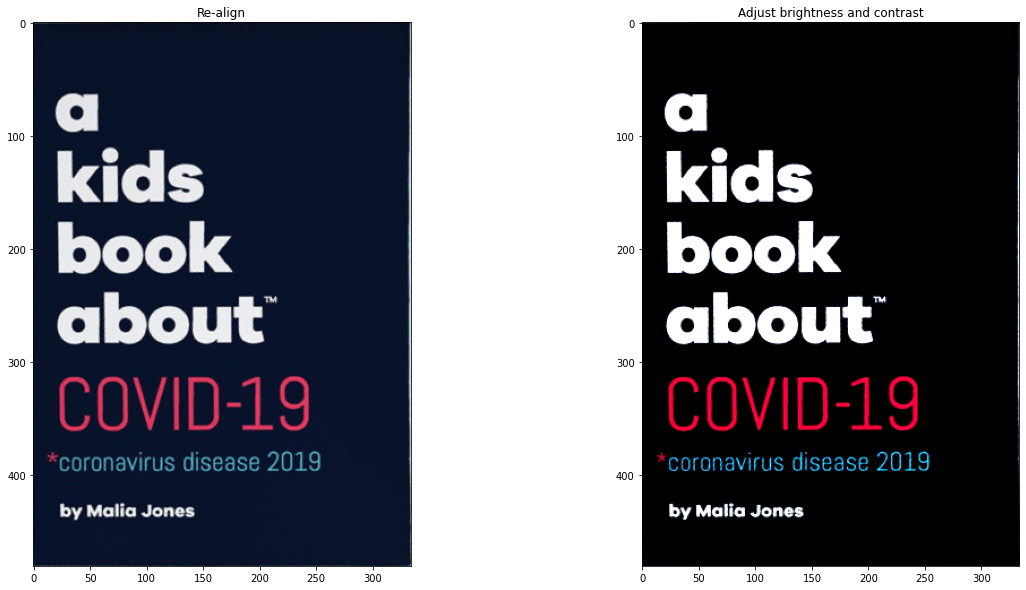

In [21]:
brightness = 255#int(input('* Enter the brightness value [0-510]: '))
contrast = 170#float(input('* Enter the contrast value [0-254]: '))

in_adjust = homo_img_cv.copy()

s = time.time()
new_image_cv = controller(in_adjust, brightness, contrast)
time_s4_cv = time.time() - s

fig, axis = plt.subplots(1,2, figsize = (20,10));

axis[0].imshow(homo_img_cv);
axis[0].set_title('Re-align');
axis[1].imshow(new_image_cv);
axis[1].set_title('Adjust brightness and contrast');

### 3.Thực thi bằng @jit

#### Step 1

In [22]:
@jit(cache=True)
def step1_host(img, gau_kernel, sobel_x_kernel, sobel_y_kernel, min_thres = 0.05, max_thres = 0.15):
    gray_py = convert_RGB_Gray_py(img)
    gaussianBlur_py = convolutionLayer_py(gray_py, gau_kernel)
    edge_sobel_py, angle_py = edgeGradient_py(gaussianBlur_py, sobel_x_kernel, sobel_y_kernel)
    non_max_sup_py = nonMaxSuppression(edge_sobel_py, angle_py)
    canny_edge_py = hysteresisThreshold(non_max_sup_py, min_thres, max_thres).astype(np.uint8)
    return canny_edge_py

In [23]:
canny_edge_py = step1_host(img, gau_kernel, sobel_x_kernel, sobel_y_kernel, min_thres = 0.05, max_thres = 0.15)

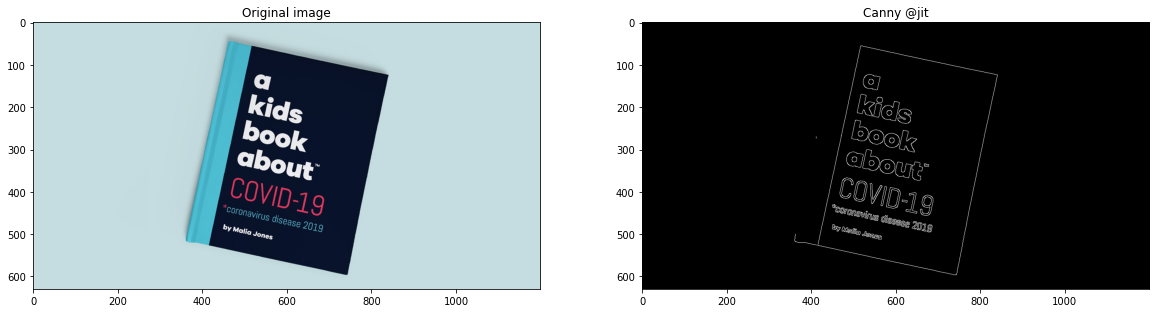

In [24]:
s = time.time()
canny_edge_py = step1_host(img, gau_kernel, sobel_x_kernel, sobel_y_kernel, min_thres = 0.05, max_thres = 0.15)
time_s1_py = time.time() - s

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(img);
axis[0].set_title('Original image');
axis[1].imshow(canny_edge_py, cmap = 'gray');
axis[1].set_title('Canny @jit');

#### Step 2

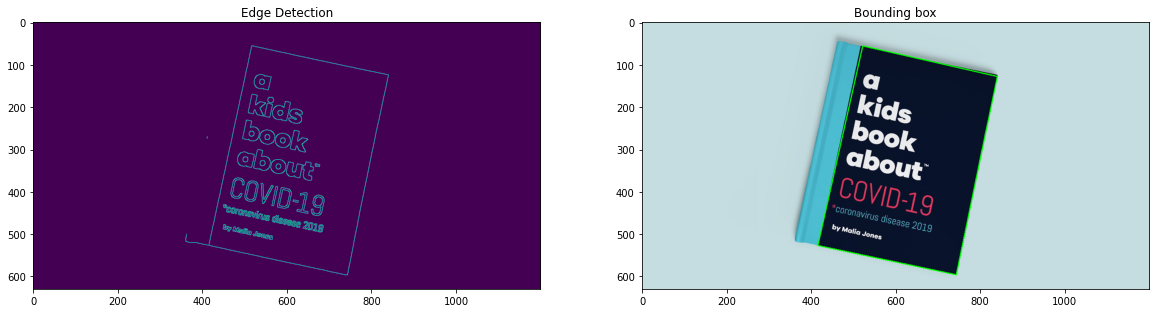

In [25]:
output_4_points_jit = img.copy()

s = time.time()
H, maxWidth, maxHeight, four_vertices_cnts_jit = step2_host(canny_edge_py)
time_s2_py = time.time() - s

cv2.drawContours(output_4_points_jit, [four_vertices_cnts_jit], 0, (0, 255, 0), 2)

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(canny_edge_py);
axis[0].set_title('Edge Detection');
axis[1].imshow(output_4_points_jit);
axis[1].set_title('Bounding box');

#### Step 3

In [26]:
@jit(cache=True)
def step3_host(img, H, maxWidth, maxHeight):
    new_i = np.zeros((maxWidth, maxHeight, img.shape[-1]), img.dtype)
    homo_img_jit = map_pos_homo(img, new_i, H).astype(int)
    return homo_img_jit

In [27]:
homo_img_jit = step3_host(img, H, maxWidth, maxHeight)

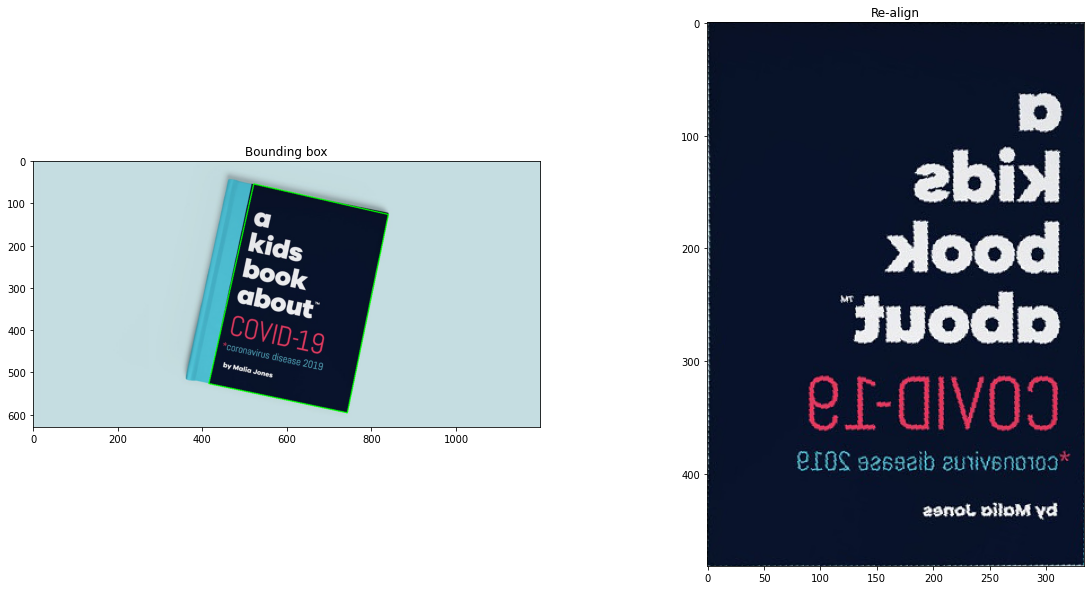

In [28]:
s = time.time()
homo_img_jit = step3_host(img, H, maxWidth, maxHeight)
time_s3_py = time.time() - s

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(output_4_points_jit);
axis[0].set_title('Bounding box');
axis[1].imshow(homo_img_jit);
axis[1].set_title('Re-align');

#### Step 4

##### Điều chỉnh độ sáng, độ tương phản

In [29]:
brightness = 255#int(input('* Enter the brightness value [0-510]: '))
contrast = 170#float(input('* Enter the contrast value [0-254]: '))

in_adjust = homo_img_jit.copy()
s = time.time()
new_image_jit = controller(in_adjust, brightness, contrast)
time_s4_py = time.time() - s

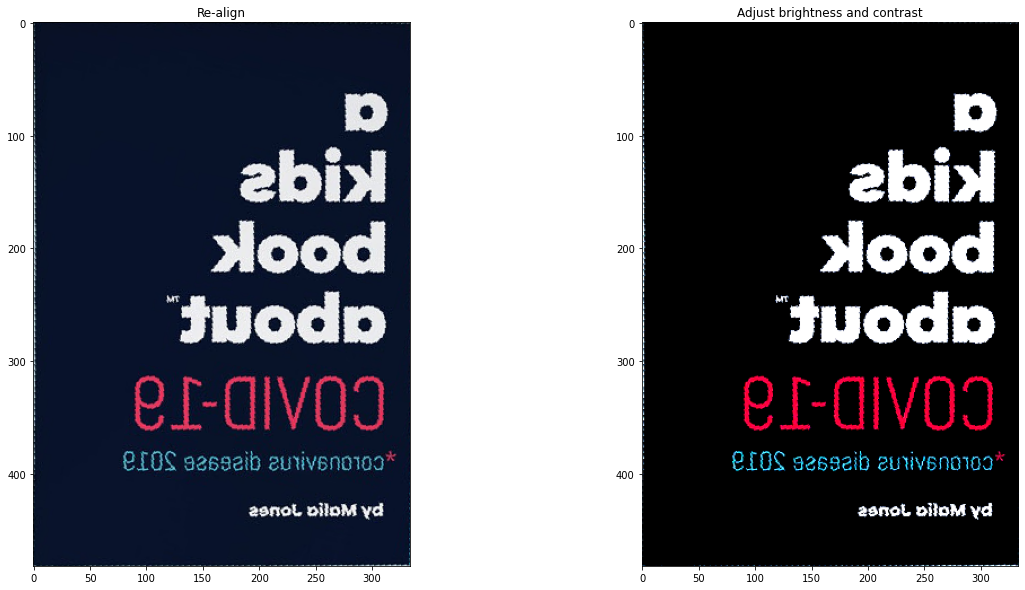

In [30]:
fig, axis = plt.subplots(1,2, figsize = (20,10));

axis[0].imshow(homo_img_jit);
axis[0].set_title('Re-align');
axis[1].imshow(new_image_jit);
axis[1].set_title('Adjust brightness and contrast');

#####  Xoay, lật ảnh

In [31]:
flip_img_jit = flipImg_py(new_image_jit, 1)

In [32]:
s = time.time()
flip_img_jit = flipImg_py(new_image_jit, 1)
time_flip_py = time.time() - s

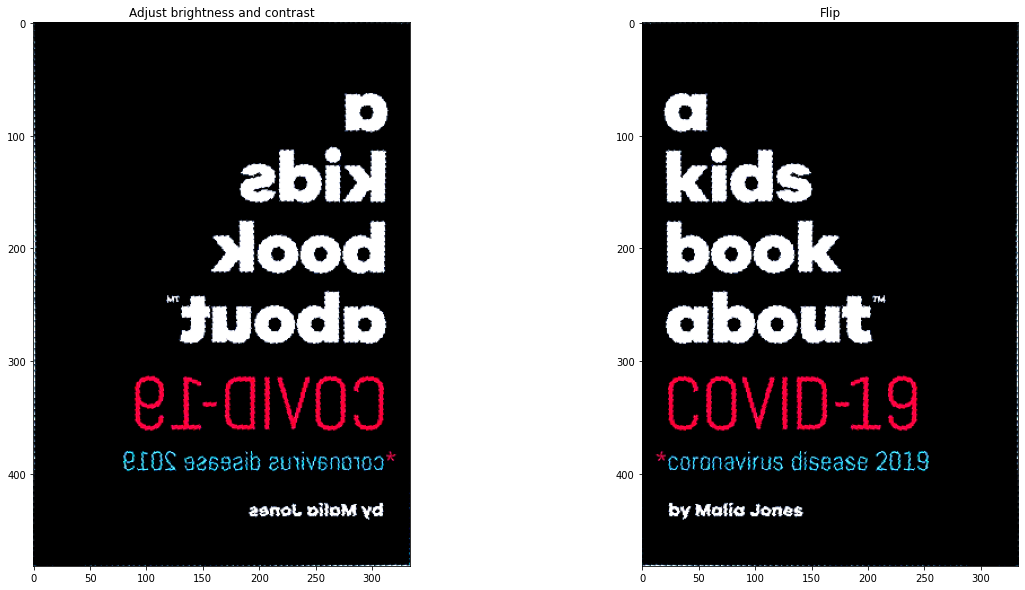

In [33]:
fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(new_image_jit);
axis[0].set_title('Adjust brightness and contrast');
axis[1].imshow(flip_img_jit);
axis[1].set_title('Flip');

### 4.So sánh

In [34]:
print("OpenCV vs Python (@jit): ", np.abs(canny_edge_cv - canny_edge_py).mean())

OpenCV vs Python (@jit):  0.11849338624338625


## III.Tổng hợp và phân tích cho việc song song

### 1.Thời gian thực thi

In [35]:
# index_cv = ['time_gray',
#             'time_blur',
#             'time_grad',
#             'time_nonmax',
#             'time_thres',
#             'time_detectEdge',
#             'time_mapHomo']

index_step = ['time_step1','time_step2','time_step3','time_step4']

# index_no_jit = ['time_findCnts',
#                 'time_4Vertices',
#                 'time_homoMatrix']

# index_py = ['time_gray',
#             'time_blur',
#             'time_grad',
#             'time_nonmax',
#             'time_thres',
#             'time_detectEdge',
#             'time_mapHomo']

# index_cache = ['time_gray',
#                'time_blur',
#                'time_grad',
#                'time_nonmax',
#                'time_thres',
#                'time_detectEdge',
#                'time_mapHomo']

data_cv = [time_s1_cv, time_s2_cv, time_s3_cv, time_s4_cv]

# data_step = [time_gray_cache + time_blur_cache + time_grad_cache + time_nonmax_cache + time_thres_cache, time_findCnts_cv + time_4Vertices_cv, time_homoMatrix_cv + time_mapHomo_cache, time_step4_py + time_flip_cache]

data_py = [time_s1_py, time_s2_py, time_s3_py, time_s4_py]

# data_no_jit = [time_findCnts_cv,
#                time_4Vertices_cv,
#                time_homoMatrix_cv]

# data_cache = [time_gray_cache,
#               time_blur_cache,
#               time_grad_cache,
#               time_nonmax_cache,
#               time_thres_cache,
#               time_blur_cache + time_grad_cache + time_nonmax_cache + time_thres_cache,
#               time_mapHomo_cache]

In [36]:
df_time_cv = pd.DataFrame(data = data_cv, index = index_step, columns = ['OpenCV (s)'])
df_time_py = pd.DataFrame(data = data_py, index = index_step, columns = ['@jit (s)'])
# df_time_cache = pd.DataFrame(data = data_cache, index = index_cache, columns = ['@jit with cache'])
# df_time_step = pd.DataFrame(data = data_step, index = index_step, columns = ['@jit with cache'])

In [37]:
df_time = pd.merge(df_time_py, df_time_cv, on=df_time_py.index, how='left').set_index('key_0')
# df_time = pd.merge(df_time, df_time_cache, on=df_time.index, how='left').set_index('key_0')

In [38]:
df_time

@jit (s)  OpenCV (s)
key_0                           
time_step1  0.121586    0.030391
time_step2  0.003899    0.009856
time_step3  0.017029    0.009526
time_step4  0.001606    0.003618

In [39]:
# df_time_step

### 2.Nhận xét
* Các bước: `xác định 4 đỉnh` (time_4Vertices), `xác định viền` (time_findCnts) và `tìm ma trận Homography` (time_homoMatrix) không phù hợp để thực hiện song song hóa. 
    * Với bước xác định 4 đỉnh, chủ yếu là tìm ra những điểm có tọa độ x hoặc y là cực đại hoặc cực tiểu sau đó xác định thứ tự của các đỉnh, lượng công việc ở đây **nhỏ** nên khi thực hiện song song hóa sẽ không cải thiện được tốc độ, có thể dẫn đến kết quả tệ hơn.
    * Bước xác định viền, do sử dụng hàm của OpenCV nên không có hàm tuần tự để có thể thiết kế, phân tích.
    * Bước tìm ma trận Homography sẽ dùng hàm của OpenCV. Nhóm quyết định sử dụng hàm OpenCV ở đây vì bước này chỉ xác định ma trận biến đối dựa trên 4 cặp đỉnh, khối lượng công việc khá nhỏ, và OpenCV có sẵn những tối ưu cho các hàm built-in của mình nên tốc độ sẽ nhanh hơn khi tự chạy bằng các hàm của Numpy.
* Thời gian thực thi của bước `tính gradient và hướng gradient` tốn nhiều thời gian nhất.
* Các bước trong step 1, 3 có thể tăng tốc bằng cách sử dụng song song vì thao tác trên các pixel là như nhau và số lượng các pixel lớn.

$⇒$ Thực hiện song song hóa cho hàm:

* `Hàm làm xám ảnh`
* `Hàm làm mờ ảnh`
* `Hàm tính gradient và hướng gradient`
* `Hàm tính non-max suppression`
* `Hàm lọc ngưỡng`
* `Hàm tính tọa độ mới`




## IV.Song song hóa

### 1.Thiết kế

- Vì các pixel trong mảng output sẽ được tính độc lập (không phụ thuộc vào các pixel khác) $\rightarrow$ Một thread sẽ xử lý một pixel tương ứng.

- Toàn bộ ma trận input sẽ được chia thành một grid với kích thước (m,n) và mỗi grid sẽ có blocksize là (32,32) vì số lượng thread tối đa của mỗi block là 1024.

In [40]:
block_size = (32,32)

### 2.Các hàm xử lý ảnh

#### a.Làm xám ảnh

In [41]:
@cuda.jit
def convert_RGB_Gray_kernel(img_in, img_out):
    c,r = cuda.grid(2)
    if r < img_in.shape[0] and c < img_in.shape[1]:
        img_out[r,c] =  round(img_in[r,c,0] * 0.2989  + img_in[r,c,1] * 0.5870 + img_in[r,c,2] * 0.1141)

#### b.Tính tích chập

In [42]:
@cuda.jit
def convolutionLayer_kernel(img_in, img_out, kernel):
    c,r = cuda.grid(2)
    if r < img_in.shape[0] and c < img_in.shape[1]:
        result = 0
        for i in range(kernel.shape[0]):
            for j in range(kernel.shape[1]):
                in_r = r - kernel.shape[0]//2 + i;
                in_c = c - kernel.shape[1]//2 + j;
                in_r = min(max(0, in_r), img_in.shape[0] - 1);
                in_c = min(max(0, in_c), img_in.shape[1] - 1);
                result += kernel[i,j] * img_in[in_r,in_c];
        img_out[r,c] = round(result)

#### c.Tính gradient và hướng gradient

In [43]:
@cuda.jit
def gradient_kernel(img_in, img_out, angle, kernel_x, kernel_y):
    c,r = cuda.grid(2)
    if r < img_in.shape[0] and c < img_in.shape[1]:
        result_x = 0
        result_y = 0
        for i in range(kernel_x.shape[0]):
            for j in range(kernel_x.shape[1]):
                in_r = r - kernel_x.shape[0]//2 + i;
                in_c = c - kernel_x.shape[1]//2 + j;
                in_r = min(max(0, in_r), img_in.shape[0] - 1);
                in_c = min(max(0, in_c), img_in.shape[1] - 1);
                result_x += kernel_x[i,j] * img_in[in_r,in_c];
                result_y += kernel_y[i,j] * img_in[in_r,in_c];
        img_out[r,c] = ((result_x ** 2) + (result_y ** 2)) ** 0.5
        angle[r,c] = math.atan2(result_y, result_x) * (180 / np.pi) 
        angle[r,c] = angle[r,c] if angle[r,c] >= 0 else angle[r,c]+180 

#### d.Tính non-max suppression

In [44]:
@cuda.jit
def nonMaxSuppression_kernel(img_in, img_out, angle):
    c,r = cuda.grid(2)
    if 0 < r < img_in.shape[0] - 1 and 0 < c < img_in.shape[1]-1:
        q, t = 255, 255
        if 0 <= angle[r,c] < 22.5 or 180 >= angle[r,c] >= 157.5:
            q, t = img_in[r, c+1], img_in[r, c-1]
        elif 67.5 > angle[r,c] >= 22.5:
            q, t = img_in[r+1, c-1], img_in[r-1, c+1]
        elif 112.5 > angle[r,c] >= 67.5:
            q, t = img_in[r+1, c], img_in[r-1, c]
        elif 157.5 > angle[r,c] >= 112.5:
            q, t = img_in[r-1, c-1], img_in[r+1, c+1]

        if img_in[r,c] >=q and img_in[r,c] >=t:
            img_out[r,c] = img_in[r,c]
        else:
            img_out[r,c] = 0
    elif r < img_in.shape[0] and c < img_in.shape[1]:
        img_out[r,c] = 0
        

#### e.Hàm lọc ngưỡng

In [45]:
@cuda.jit
def hysteresisThreshold_kernel(img_in,img_out, min_val, max_val):
    c, r = cuda.grid(2)
    if r < img_in.shape[0] and c < img_in.shape[1]:
        if img_in[r,c] > max_val:
            img_out[r,c] = 255
        elif img_in[r,c] > min_val:
            is_edge = False
            for i in range(max(0, r-1), min(img_in.shape[0], r+2)):
                for j in range(max(0, c-1), min(img_in.shape[1], c+2)):
                    if img_in[i,j] > max_val:
                        is_edge = True
                        img_out[r,c] = 255
                        break
                if is_edge:
                    break
        else:
            img_out[r,c] = 0

#### f.Map tọa độ mới cho ảnh

In [46]:
@cuda.jit
def map_homo_kernel(img_in, img_out, H):
    c,r = cuda.grid(2)
    if r < img_out.shape[0] and c < img_out.shape[1]:
        x = int((H[0,0] * c + H[0,1] * r + H[0,2]) / (H[2,0] * c + H[2,1] * r + H[2,2]))
        y = int((H[1,0] * c + H[1,1] * r + H[1,2]) / (H[2,0] * c + H[2,1] * r + H[2,2]))
        x = int(x) + 1 if (x*100) % 100 > 50 else int(x)
        y = int(y) + 1 if (y*100) % 100 > 50 else int(y)
        if 0 <= y < img_in.shape[0] and 0 <= x < img_in.shape[1]:
            img_out[r, c, 0], img_out[r, c, 1], img_out[r, c, 2] = img_in[y, x, 0], img_in[y, x, 1], img_in[y, x, 2]            

### 3.Thực thi

#### a.Làm xám ảnh

**Compiler**

In [47]:
gray_kernel = np.zeros((img.shape[0], img.shape[1]))

grid_size = (math.ceil(gray_kernel.shape[1] / block_size[0]), #chieu x
             math.ceil(gray_kernel.shape[0] / block_size[1])) #chieu y

s = time.time()
convert_RGB_Gray_kernel[grid_size, block_size](img, gray_kernel)
time_gray_comp = time.time() - s

**Run**

In [48]:
gray_kernel = np.zeros((img.shape[0], img.shape[1]))

grid_size = (math.ceil(gray_kernel.shape[1] / block_size[0]), #chieu x
             math.ceil(gray_kernel.shape[0] / block_size[1])) #chieu y

s = time.time()
convert_RGB_Gray_kernel[grid_size, block_size](img, gray_kernel)
time_gray_pp = time.time() - s

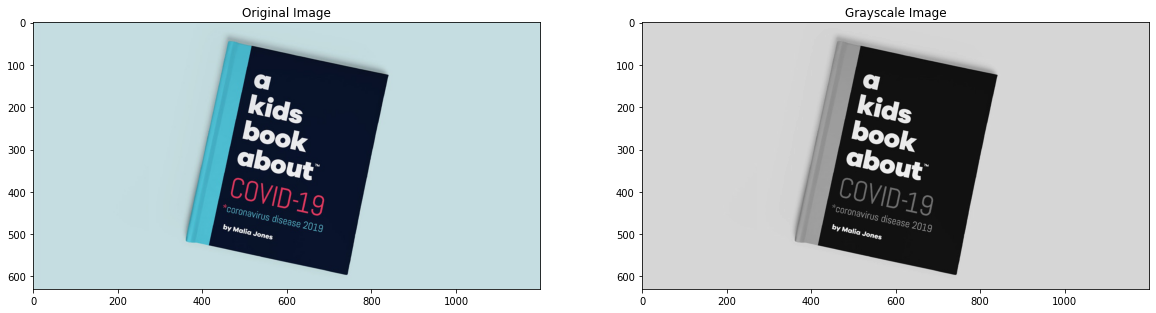

In [49]:
fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(img);
axis[0].set_title('Original Image');
axis[1].imshow(gray_kernel, cmap = 'gray');
axis[1].set_title('Grayscale Image');

In [50]:
# print("OpenCV vs @cuda.jit: ", np.abs(gray_cv - gray_kernel).mean())
# print("@jit vs @cuda.jit: ", np.abs(gray_py - gray_kernel).mean())

#### b.Xác định biên cạnh

##### Làm mờ ảnh

**Compiler**

In [51]:
conv = np.zeros(gray_kernel.shape)

grid_size = (math.ceil(conv.shape[1] / block_size[0]), #chieu x
             math.ceil(conv.shape[0] / block_size[1])) #chieu y

s = time.time()
convolutionLayer_kernel[grid_size, block_size](gray_kernel, conv, gau_kernel)
time_blur_comp = time.time() - s

**Run**

In [52]:
conv = np.zeros(gray_kernel.shape)

grid_size = (math.ceil(conv.shape[1] / block_size[0]), #chieu x
             math.ceil(conv.shape[0] / block_size[1])) #chieu y

s = time.time()
convolutionLayer_kernel[grid_size, block_size](gray_kernel, conv, gau_kernel)
time_blur_pp = time.time() - s

##### Tính gradient và hướng gradient

**Compiler**

In [53]:
edge_gradient = np.zeros(gray_kernel.shape)
angle_kernel = np.zeros(gray_kernel.shape)

grid_size = (math.ceil(edge_gradient.shape[1] / block_size[0]), #chieu x
             math.ceil(edge_gradient.shape[0] / block_size[1])) #chieu y

s = time.time()
gradient_kernel[grid_size, block_size](conv, edge_gradient, angle_kernel, sobel_x_kernel, sobel_y_kernel)
time_grad_comp = time.time() - s

**Run**

In [54]:
edge_gradient = np.zeros(gray_kernel.shape)
angle_kernel = np.zeros(gray_kernel.shape)

grid_size = (math.ceil(edge_gradient.shape[1] / block_size[0]), #chieu x
             math.ceil(edge_gradient.shape[0] / block_size[1])) #chieu y

s = time.time()
gradient_kernel[grid_size, block_size](conv, edge_gradient, angle_kernel, sobel_x_kernel, sobel_y_kernel)
time_grad_pp = time.time() - s

In [55]:
# print("@jit vs @cuda.jit: ", np.abs(edge_sobel_py - edge_gradient).mean())

##### Tính non-max suppression

**Compiler**

In [56]:
non_max_kernel = np.zeros(edge_gradient.shape)

grid_size = (math.ceil(edge_gradient.shape[1] / block_size[0]), #chieu x
             math.ceil(edge_gradient.shape[0] / block_size[1])) #chieu y

s = time.time()
nonMaxSuppression_kernel[grid_size, block_size](edge_gradient, non_max_kernel, angle_kernel)
time_nonmax_comp = time.time() - s

**Run**

In [57]:
non_max_kernel = np.zeros(edge_gradient.shape)

grid_size = (math.ceil(edge_gradient.shape[1] / block_size[0]), #chieu x
             math.ceil(edge_gradient.shape[0] / block_size[1])) #chieu y

s = time.time()
nonMaxSuppression_kernel[grid_size, block_size](edge_gradient, non_max_kernel, angle_kernel)
time_nonmax_pp = time.time() - s

In [58]:
# print("@jit vs @cuda.jit: ", np.abs(non_max_sup_py - non_max_kernel).mean())

##### Hàm lọc ngưỡng

**Compiler**

In [59]:
min_thres = 0.05
max_thres = 0.15

max_val = non_max_kernel.max() * max_thres
min_val = max_val * min_thres

canny_edge_kernel = np.zeros(non_max_kernel.shape, np.int32)

grid_size = (math.ceil(non_max_kernel.shape[1] / block_size[0]), #chieu x
             math.ceil(non_max_kernel.shape[0] / block_size[1])) #chieu y

s = time.time()
hysteresisThreshold_kernel[grid_size, block_size](non_max_kernel, canny_edge_kernel, min_val, max_val)
time_thres_comp = time.time() - s

**Run**

In [60]:
min_thres = 0.05
max_thres = 0.15

max_val = non_max_kernel.max() * max_thres
min_val = max_val * min_thres

canny_edge_kernel = np.zeros(non_max_kernel.shape, np.int32)

grid_size = (math.ceil(non_max_kernel.shape[1] / block_size[0]), #chieu x
             math.ceil(non_max_kernel.shape[0] / block_size[1])) #chieu y

s = time.time()
hysteresisThreshold_kernel[grid_size, block_size](non_max_kernel, canny_edge_kernel, min_val, max_val)
time_thres_pp = time.time() - s

canny_edge_kernel  = canny_edge_kernel.astype(np.uint8)

In [61]:
print("@jit vs @cuda.jit: ", np.abs(canny_edge_py - canny_edge_kernel).mean())

@jit vs @cuda.jit:  0.0


#### c.Tìm viền ảnh

In [62]:
cnts_kernel, _ = cv2.findContours(canny_edge_kernel.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts_kernel = sorted(cnts_kernel, key = lambda x:cv2.arcLength(x,True), reverse = True)

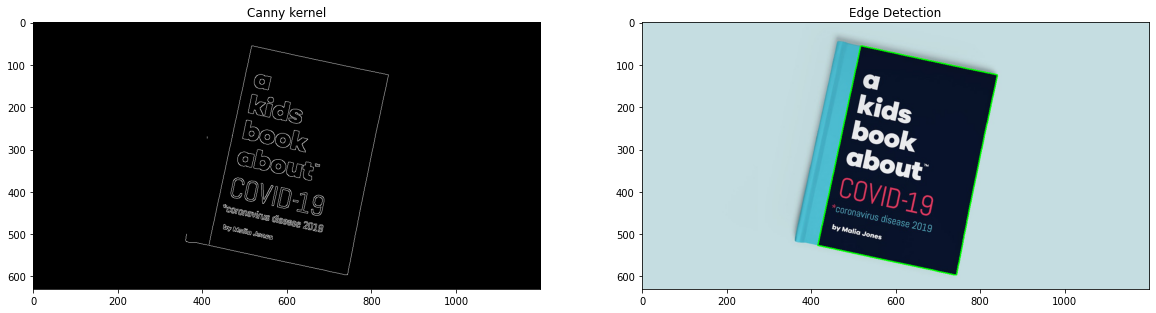

In [63]:
output_edge_kernel = img.copy()
cv2.drawContours(output_edge_kernel, cnts_kernel, 0, (0, 255, 0), 2)

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(canny_edge_kernel, cmap='gray');
axis[0].set_title('Canny kernel');
axis[1].imshow(output_edge_kernel);
axis[1].set_title('Edge Detection');

In [64]:
# print("@jit vs @cuda.jit: ", np.abs(output_edge_jit - output_edge_kernel).mean())

#### d.Tìm ma trận Homography

In [65]:
choosen_cnt = cnts_kernel[0].squeeze()

max_x, max_y = choosen_cnt[:,0].max(),choosen_cnt[:,1].max()
min_x, min_y = choosen_cnt[:,0].min(), choosen_cnt[:,1].min()

b_can, t_can = choosen_cnt[choosen_cnt[:,0] == max_x], choosen_cnt[choosen_cnt[:,0] == min_x]
l_can, r_can = choosen_cnt[choosen_cnt[:,1] == min_y], choosen_cnt[choosen_cnt[:,1] == max_y]

t, b = get_pos(t_can, min_y, max_y, 1), get_pos(b_can, min_y, max_y, 1)
l, r = get_pos(l_can, min_x, max_x, 0), get_pos(r_can, min_x, max_x, 0)

four_vertices_cnts_kernel = []

get_4_vertices(t, l, r, b, four_vertices_cnts_kernel)
four_vertices_cnts_kernel = order_points_py(four_vertices_cnts_kernel, max_x, max_y, min_x, min_y)

tl, tr, br, bl = four_vertices_cnts_kernel

widthA = ((br[0] - bl[0]) ** 2 + (br[1] - bl[1]) ** 2) ** 0.5
widthB = ((tr[0] - tl[0]) ** 2 + (tr[1] - tl[1]) ** 2) ** 0.5

maxWidth = int(widthA) if int(widthA) > int(widthB) else int(widthB)

heightA = ((tr[0] - br[0]) ** 2 + (tr[1] - br[1]) ** 2) ** 0.5
heightB = ((tl[0] - bl[0]) ** 2 + (tl[1] - bl[1]) ** 2) ** 0.5

maxHeight = int(heightA) if int(heightA) > int(heightB) else int(heightB)

n_four_vertices_cnts_kernel = [n_tl, n_tr, n_br, n_bl] = np.array([[0,0], 
                                                   [0, maxWidth-1], 
                                                   [maxHeight-1, maxWidth - 1], 
                                                   [maxHeight - 1, 0]], dtype = 'float32')

H = np.linalg.inv(cv2.getPerspectiveTransform(four_vertices_cnts_kernel.astype('float32'), n_four_vertices_cnts_kernel))

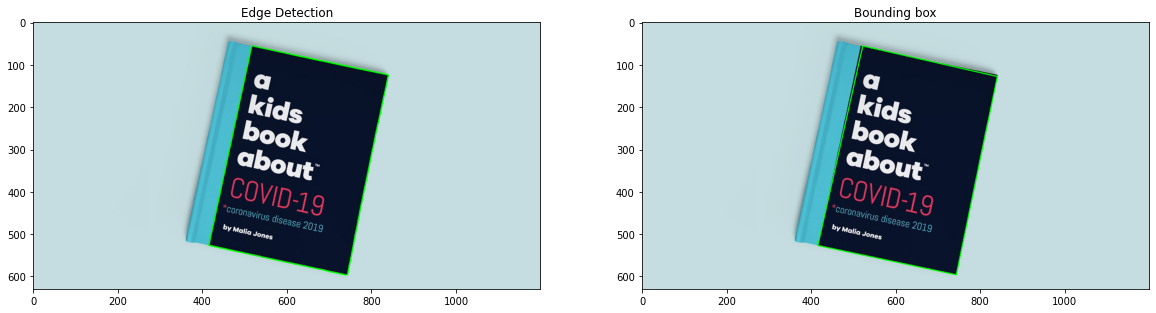

In [66]:
output_4_points_kernel = img.copy()
cv2.drawContours(output_4_points_kernel, [four_vertices_cnts_kernel], 0, (0, 255, 0), 2)

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(output_edge_kernel);
axis[0].set_title('Edge Detection');
axis[1].imshow(output_4_points_kernel);
axis[1].set_title('Bounding box');

#### e.Map tọa độ mới cho ảnh

**Compiler**

In [67]:
homo_img_pp = np.zeros((maxWidth, maxHeight, img.shape[-1]), img.dtype)
grid_size = (math.ceil(maxHeight / block_size[0]), #chieu x
             math.ceil(maxWidth / block_size[1])) #chieu y

s = time.time()
map_homo_kernel[grid_size, block_size](img, homo_img_pp, H)
time_mapHomo_comp = time.time() - s


homo_img_pp = homo_img_pp.astype(int)

**Run**

In [68]:
homo_img_pp = np.zeros((maxWidth, maxHeight, img.shape[-1]), img.dtype)
grid_size = (math.ceil(maxHeight / block_size[0]), #chieu x
             math.ceil(maxWidth / block_size[1])) #chieu y

s = time.time()
map_homo_kernel[grid_size, block_size](img, homo_img_pp, H)
time_mapHomo_pp = time.time() - s

homo_img_pp = homo_img_pp.astype(int)

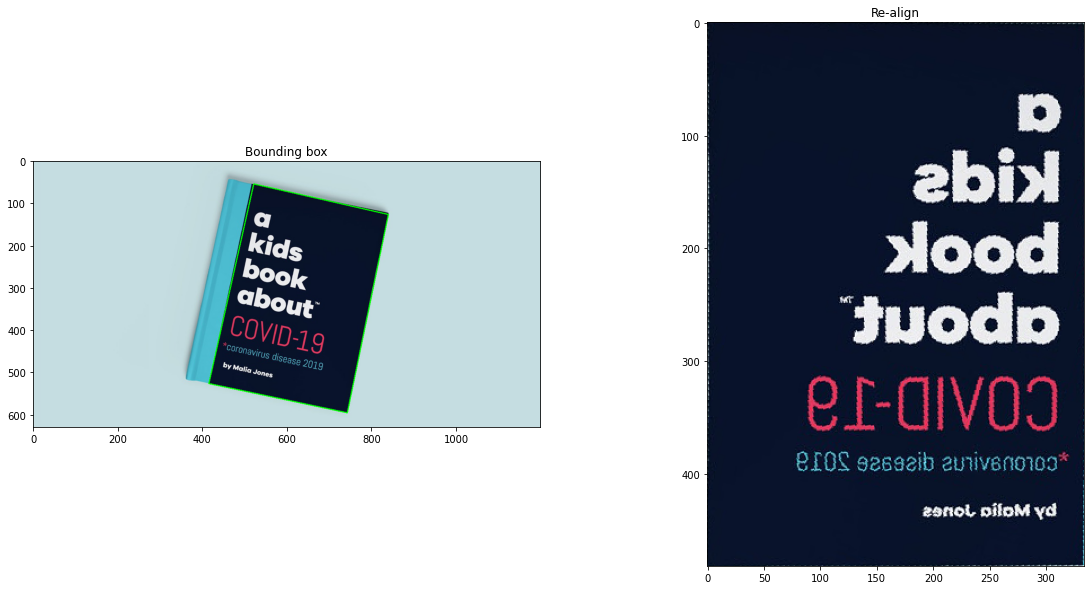

In [69]:
fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(output_4_points_kernel);
axis[0].set_title('Bounding box');
axis[1].imshow(homo_img_pp);
axis[1].set_title('Re-align');

#### f.Hàm điều chỉnh độ sáng, độ tương phản

In [70]:
brightness = 255#int(input('* Enter the brightness value [0-510]: '))
contrast = 170#float(input('* Enter the contrast value [0-254]: '))

in_adjust = homo_img_pp.copy()
s = time.time()
new_image_pp = controller(in_adjust, brightness, contrast)
time_step4_pp = time.time() - s

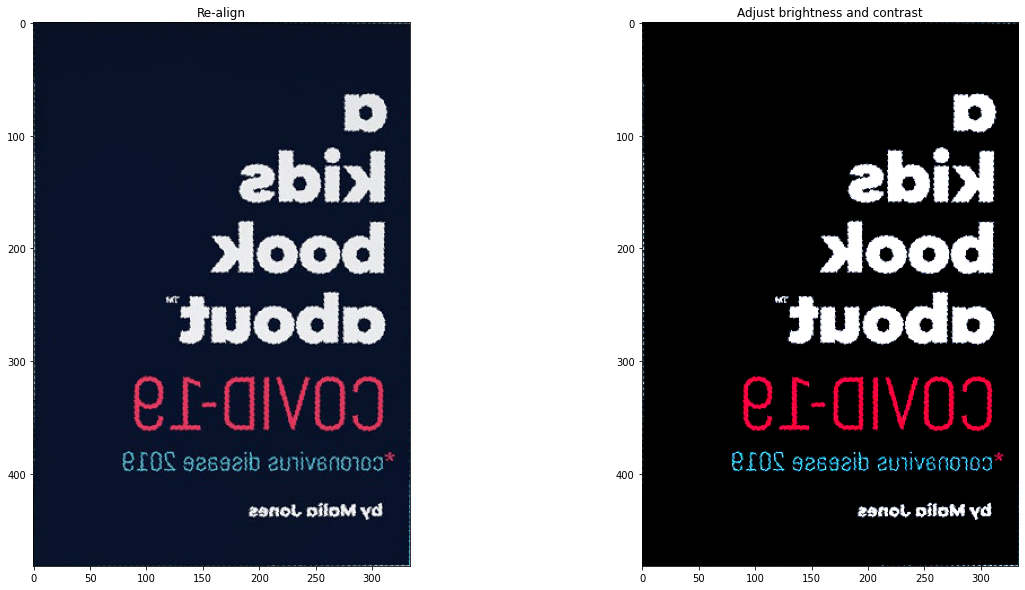

In [71]:
fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(homo_img_pp);
axis[0].set_title('Re-align');
axis[1].imshow(new_image_pp);
axis[1].set_title('Adjust brightness and contrast');

### 4.Đánh giá

In [72]:
index_comp = ['time_gray_comp',
            'time_blur_comp',
            'time_grad_comp',
            'time_nonmax_comp',
            'time_thres_comp',
            'time_detectEdge',
            'time_mapHomo']

data_comp = [time_gray_comp,
            time_blur_comp,
            time_grad_comp,
            time_nonmax_comp,
            time_thres_comp,
            time_blur_comp + time_grad_comp + time_nonmax_comp + time_thres_comp,
            time_mapHomo_comp]

data_pp = [time_gray_pp,
           time_blur_pp,
           time_grad_pp,
           time_nonmax_pp,
           time_thres_pp,
           time_blur_pp + time_grad_pp + time_nonmax_pp + time_thres_pp,
           time_mapHomo_pp]
 
index_pp = ['time_gray_pp',
            'time_blur_pp',
            'time_grad_pp',
            'time_nonmax_pp',
            'time_thres_pp',
            'time_detectEdge',
            'time_mapHomo']

# data_step_pp = [time_gray_pp + time_blur_pp + time_grad_pp + time_nonmax_pp + time_thres_pp, time_findCnts_cv + time_4Vertices_cv, time_homoMatrix_cv + time_mapHomo_pp, time_step4_pp]
# index_step_pp = ['time_step1','time_step2','time_step3','time_step4']

In [73]:
df_time_pp1 = pd.DataFrame(data = data_pp, index = index_pp, columns = ['pp_run'])
df_time_comp1 = pd.DataFrame(data = data_comp, index = index_comp, columns = ['pp_comp'])
# df_time_step_pp = pd.DataFrame(data = data_step_pp, index = index_step_pp, columns = ['pp'])

In [74]:
# df_time = pd.merge(df_time, df_time_comp1, on=df_time.index, how='left').set_index('key_0')
# df_time = pd.merge(df_time, df_time_pp1, on=df_time.index, how='left').set_index('key_0')
# df_time_step = pd.merge(df_time_step, df_time_step_pp, on=df_time_step.index, how='left').set_index('key_0')

In [75]:
df_time

@jit (s)  OpenCV (s)
key_0                           
time_step1  0.121586    0.030391
time_step2  0.003899    0.009856
time_step3  0.017029    0.009526
time_step4  0.001606    0.003618

* Nhận xét
    * Thời gian làm mờ ảnh của song song nhanh hơn nhiều so với bản @jit đã cache và có phần nhỉnh hơn bản OpenCV.
    * Trong các hàm thì thời gian tính gradient là lâu nhất (đối với pp_run).
    * Thời gian chạy của các hàm phiên bản song song nhanh hơn so với @jit đã cache, trừ phần điều chỉnh độ sáng, độ tương phản.    
    * Hàm mapHomo của OpenCV chậm hơn nhiều so với phiên bản song song của nhóm $\rightarrow$ ở hàm này OpenCV có tối ưu nhưng nhóm không thể biết được họ thực hiện như thế nào.

In [76]:
# df_time_step

* Nhận xét
    * Thời gian chạy của bước 2 là một, nhóm không đo lại thời gian các bước này vì các bước xử lý là như nhau.
    * Bước 1 và 3 ở phiên bản song song có phần cải thiện so với @jit đã cache, tuy nhiên thời gian của bước 1 vẫn còn khá lớn.
    * Bước 4 được xử lý như nhau ở các phiên bản.

* Phân tích thời gian chạy bằng nvprof

In [77]:
%%writefile parallel.py
import numpy as np
from numba import *
from PIL import *
import requests
from io import BytesIO
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
import math
import time
from numba import jit, cuda
from PIL import Image
import argparse
import sys

from itertools import permutations
import pandas as pd

from skimage.filters import threshold_local


import warnings
warnings.filterwarnings('ignore')

parser = argparse.ArgumentParser()
parser.add_argument('--image_path', type=str, default= '../input/image-test/kid.png', help='image path')
parser.add_argument('--block_size', type=int, default= 32, help='block size')
parser.add_argument('--min_thres', type=float, default=0.05, help='min_thres')
parser.add_argument('--max_thres', type=float, default=0.15, help='max_thres')
parser.add_argument('--alpha', type=float, default=1.5, help='alpha')
parser.add_argument('--beta', type=float, default=3, help='beta')

opt = parser.parse_args()
print(opt)
img_path = opt.image_path
block_size = (32,32)
min_thres = opt.min_thres
max_thres = opt.max_thres
alpha = opt.alpha
beta = opt.beta
gau_kernel_size = 3

# img_path = '../input/image-test/kid.png'
# block_size = (32,32)
# min_thres = 0.05
# max_thres = 0.15
# alpha = 1.5
# beta = 3
# gau_kernel_size = 3

img = np.asarray(Image.open(img_path))

gau_kernel = cv2.getGaussianKernel(gau_kernel_size**2,1)
gau_kernel = gau_kernel.reshape((gau_kernel_size,gau_kernel_size))

sobel_x_kernel, sobel_y_kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], np.float32), np.array([[1,2,1],[0,0,0],[-1,-2,-1]], np.float32)
# sobel_x_kernel = np.flip(sobel_x_kernel)
# sobel_y_kernel = np.flip(sobel_y_kernel)

def get_pos (lst_can, min, max, pos = 0):
    if len(lst_can[(lst_can[:,pos] == min) | (lst_can[:,pos] == max)]) == 0:
        ans1 = lst_can[lst_can[:,pos] == lst_can[:,pos].max()]
        return ans1[0], -1
    else:
        if  len(lst_can[(lst_can[:,pos] == min) | (lst_can[:,pos] == max)]) == 2:
            ans1 = lst_can[(lst_can[:,pos] == min)]
            ans2 = lst_can[(lst_can[:,pos] == max)]
            return ans1[0], ans2[0]
        else:
            if  len(lst_can[(lst_can[:,pos] == max)]) == 1:
                ans2 = lst_can[(lst_can[:,pos] == max)]
                return ans2[0], -1
            else:
                ans2 = lst_can[(lst_can[:,pos] == min)]
                return ans2[0], -1

def get_points(xy, lst):
    if xy[1] == -1:
        lst.append(xy[0])
    else:
        lst.extend(xy)

def get_4_vertices(t, l, r, b, lst_v):
    lst = []

    get_points(list(t), lst)
    get_points(list(l), lst)
    get_points(list(r), lst)
    get_points(list(b), lst)

    for i in range(len(lst)):
        flag = False
        for j in range(len(lst_v)):
            comp = lst[i] == lst_v[j]
            if comp.any():
                flag = True
        if not flag:
            lst_v.append(lst[i])

def order_points_py(pts, max_x, max_y, min_x, min_y):
    lst = [i for i in range(len(pts))]
    pts_permutations = set(permutations(lst))
    for i in pts_permutations:
        t1, t2, s1, s2 = pts[i[0]], pts[i[1]], pts[i[2]], pts[i[3]]
        A = np.array([[t1[0], 1], 
                    [t2[0], 1]])
        y = np.array([t1[1], t2[1]])

        x1 = np.linalg.solve(A, y)

        A = np.array([[s1[0], 1], 
                    [s2[0], 1]])
        y = np.array([s1[1], s2[1]])

        x2 = np.linalg.solve(A, y)

        x  = (x2[1] - x1[1]) / (x1[0] - x2[0])
        x = x if min_x < x < max_x else -1

        y = x1[0] * x + x1[1]
        y = y if min_y < y < max_y else -1

        if x != -1 and y != -1:
            return np.array([t1, s1, t2, s2]) #tl, tr, br, bl

@cuda.jit
def convert_RGB_Gray_kernel(img_in, img_out):
    c,r = cuda.grid(2)
    if r < img_in.shape[0] and c < img_in.shape[1]:
        img_out[r,c] =  round(img_in[r,c,0] * 0.2989  + img_in[r,c,1] * 0.5870 + img_in[r,c,2] * 0.1141)

@cuda.jit
def convolutionLayer_kernel(img_in, img_out, kernel):
    c,r = cuda.grid(2)
    if r < img_in.shape[0] and c < img_in.shape[1]:
        result = 0
        for i in range(kernel.shape[0]):
            for j in range(kernel.shape[1]):
                in_r = r - kernel.shape[0]//2 + i;
                in_c = c - kernel.shape[1]//2 + j;
                in_r = min(max(0, in_r), img_in.shape[0] - 1);
                in_c = min(max(0, in_c), img_in.shape[1] - 1);
                result += kernel[i,j] * img_in[in_r,in_c];
        img_out[r,c] = round(result)


@cuda.jit
def gradient_kernel(img_in, img_out, angle, kernel_x, kernel_y):
    c,r = cuda.grid(2)
    if r < img_in.shape[0] and c < img_in.shape[1]:
        result_x = 0
        result_y = 0
        for i in range(kernel_x.shape[0]):
            for j in range(kernel_x.shape[1]):
                in_r = r - kernel_x.shape[0]//2 + i;
                in_c = c - kernel_x.shape[1]//2 + j;
                in_r = min(max(0, in_r), img_in.shape[0] - 1);
                in_c = min(max(0, in_c), img_in.shape[1] - 1);
                result_x += kernel_x[i,j] * img_in[in_r,in_c];
                result_y += kernel_y[i,j] * img_in[in_r,in_c];
        img_out[r,c] = ((result_x ** 2) + (result_y ** 2)) ** 0.5
        angle[r,c] = math.atan2(result_y, result_x) * (180 / np.pi) 
        angle[r,c] = angle[r,c] if angle[r,c] >= 0 else angle[r,c]+180 

@cuda.jit
def nonMaxSuppression_kernel(img_in, img_out, angle):
    c,r = cuda.grid(2)
    if 0 < r < img_in.shape[0] - 1 and 0 < c < img_in.shape[1]-1:
        q, t = 255, 255
        if 0 <= angle[r,c] < 22.5 or 180 >= angle[r,c] >= 157.5:
            q, t = img_in[r, c+1], img_in[r, c-1]
        elif 67.5 > angle[r,c] >= 22.5:
            q, t = img_in[r+1, c-1], img_in[r-1, c+1]
        elif 112.5 > angle[r,c] >= 67.5:
            q, t = img_in[r+1, c], img_in[r-1, c]
        elif 157.5 > angle[r,c] >= 112.5:
            q, t = img_in[r-1, c-1], img_in[r+1, c+1]

        if img_in[r,c] >=q and img_in[r,c] >=t:
            img_out[r,c] = img_in[r,c]
        else:
            img_out[r,c] = 0
    elif r < img_in.shape[0] and c < img_in.shape[1]:
        img_out[r,c] = 0
        

@cuda.jit
def hysteresisThreshold_kernel(img_in,img_out, min_val, max_val):
    c, r = cuda.grid(2)
    if r < img_in.shape[0] and c < img_in.shape[1]:
        if img_in[r,c] > max_val:
            img_out[r,c] = 255
        elif img_in[r,c] > min_val:
            is_edge = False
            for i in range(max(0, r-1), min(img_in.shape[0], r+2)):
                for j in range(max(0, c-1), min(img_in.shape[1], c+2)):
                    if img_in[i,j] > max_val:
                        is_edge = True
                        img_out[r,c] = 255
                        break
                if is_edge:
                    break
        else:
            img_out[r,c] = 0

@cuda.jit
def map_homo_kernel(img_in, img_out, H):
    c,r = cuda.grid(2)
    if r < img_out.shape[0] and c < img_out.shape[0]:
        x = (H[0,0] * c + H[0,1] * r + H[0,2]) / (H[2,0] * c + H[2,1] * r + H[2,2])
        y = (H[1,0] * c + H[1,1] * r + H[1,2]) / (H[2,0] * c + H[2,1] * r + H[2,2])
        x = int(x) + 1 if (x*100) % 100 > 50 else int(x)
        y = int(y) + 1 if (y*100) % 100 > 50 else int(y)
        if 0 <= y < img_in.shape[0] and 0 <= x < img_in.shape[1]:
            img_out[r, c, 0], img_out[r, c, 1], img_out[r, c, 2] = img_in[y, x, 0], img_in[y, x, 1], img_in[y, x, 2]
                        
def controller(img, brightness=255, contrast=127):
    brightness = int((brightness - 0) * (255 - (-255)) / (510 - 0) + (-255))
    contrast = int((contrast - 0) * (127 - (-127)) / (254 - 0) + (-127))
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            max = 255
        else:
            shadow = 0
            max = 255 + brightness

        al_pha = (max - shadow) / 255
        ga_mma = shadow

        # The function addWeighted calculates
        # the weighted sum of two arrays
        cal = cv2.addWeighted(img, al_pha,img, 0, ga_mma)
    else:
        cal = img

    if contrast != 0:
        Alpha = float(131 * (contrast + 127)) / (127 * (131 - contrast))
        Gamma = 127 * (1 - Alpha)

        # The function addWeighted calculates
        # the weighted sum of two arrays
        cal = cv2.addWeighted(cal, Alpha,cal, 0, Gamma)
    return cal


s = time.time()

gray_kernel = np.zeros((img.shape[0], img.shape[1]))

grid_size = (math.ceil(gray_kernel.shape[1] / block_size[0]), #chieu x
             math.ceil(gray_kernel.shape[0] / block_size[1])) #chieu y

convert_RGB_Gray_kernel[grid_size, block_size](img, gray_kernel)

conv = np.zeros(gray_kernel.shape)

grid_size = (math.ceil(conv.shape[1] / block_size[0]), #chieu x
             math.ceil(conv.shape[0] / block_size[1])) #chieu y

convolutionLayer_kernel[grid_size, block_size](gray_kernel, conv, gau_kernel)


edge_gradient = np.zeros(gray_kernel.shape)
angle_kernel = np.zeros(gray_kernel.shape)

grid_size = (math.ceil(edge_gradient.shape[1] / block_size[0]), #chieu x
             math.ceil(edge_gradient.shape[0] / block_size[1])) #chieu y

gradient_kernel[grid_size, block_size](conv, edge_gradient, angle_kernel, sobel_x_kernel, sobel_y_kernel)


non_max_kernel = np.zeros(edge_gradient.shape)

grid_size = (math.ceil(edge_gradient.shape[1] / block_size[0]), #chieu x
             math.ceil(edge_gradient.shape[0] / block_size[1])) #chieu y

nonMaxSuppression_kernel[grid_size, block_size](edge_gradient, non_max_kernel, angle_kernel)


max_val = img.max() * max_thres
min_val = max_val * min_thres

canny_edge_kernel = np.zeros(non_max_kernel.shape, np.int32)

grid_size = (math.ceil(non_max_kernel.shape[1] / block_size[0]), #chieu x
             math.ceil(non_max_kernel.shape[0] / block_size[1])) #chieu y

hysteresisThreshold_kernel[grid_size, block_size](non_max_kernel, canny_edge_kernel, min_val, max_val)


canny_edge_kernel  = canny_edge_kernel.astype(np.uint8)


cnts, _ = cv2.findContours(canny_edge_kernel.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key = lambda x:cv2.arcLength(x,True), reverse = True)
choosen_cnt = cnts[0].squeeze()

max_x, max_y = choosen_cnt[:,0].max(),choosen_cnt[:,1].max()
min_x, min_y = choosen_cnt[:,0].min(), choosen_cnt[:,1].min()

b_can, t_can = choosen_cnt[choosen_cnt[:,0] == max_x], choosen_cnt[choosen_cnt[:,0] == min_x]
l_can, r_can = choosen_cnt[choosen_cnt[:,1] == min_y], choosen_cnt[choosen_cnt[:,1] == max_y]

t, b = get_pos(t_can, min_y, max_y, 1), get_pos(b_can, min_y, max_y, 1)
l, r = get_pos(l_can, min_x, max_x, 0), get_pos(r_can, min_x, max_x, 0)

four_vertices_cnts = []

get_4_vertices(t, l, r, b, four_vertices_cnts)
four_vertices_cnts = order_points_py(four_vertices_cnts, max_x, max_y, min_x, min_y)

tl, tr, br, bl = four_vertices_cnts

widthA = ((br[0] - bl[0]) ** 2 + (br[1] - bl[1]) ** 2) ** 0.5
widthB = ((tr[0] - tl[0]) ** 2 + (tr[1] - tl[1]) ** 2) ** 0.5

maxWidth = int(widthA) if int(widthA) > int(widthB) else int(widthB)

heightA = ((tr[0] - br[0]) ** 2 + (tr[1] - br[1]) ** 2) ** 0.5
heightB = ((tl[0] - bl[0]) ** 2 + (tl[1] - bl[1]) ** 2) ** 0.5

maxHeight = int(heightA) if int(heightA) > int(heightB) else int(heightB)

n_four_vertices_cnts = [n_tl, n_tr, n_br, n_bl] = np.array([[0,0], 
                                                   [0, maxWidth-1], 
                                                   [maxHeight-1, maxWidth - 1], 
                                                   [maxHeight - 1, 0]], dtype = 'float32')

H = np.linalg.inv(cv2.getPerspectiveTransform(four_vertices_cnts.astype('float32'), n_four_vertices_cnts))


homo_img_pp = np.zeros((maxWidth, maxHeight, img.shape[-1]), img.dtype)
grid_size = (math.ceil(maxHeight / block_size[0]), #chieu x
             math.ceil(maxWidth / block_size[1])) #chieu y

map_homo_kernel[grid_size, block_size](img, homo_img_pp, H)


homo_img_pp = homo_img_pp.astype(int)


brightness = 255#int(input('* Enter the brightness value [0-510]: '))
contrast = 170#float(input('* Enter the contrast value [0-254]: '))

in_adjust = homo_img_pp.copy()
new_image_jit = controller(in_adjust, brightness, contrast)

print()
print()
print(time.time() - s)
print()
print()

# plt.imsave('after_adjust_pp.jpeg', new_image_jit.astype(np.uint8))
# plt.imsave('homo_map_pp.jpeg', homo_img_pp.astype(np.uint8))

Writing parallel.py


In [78]:
!nvprof --print-gpu-trace python parallel.py 

Namespace(alpha=1.5, beta=3, block_size=32, image_path='../input/image-test/kid.png', max_thres=0.15, min_thres=0.05)
==82== NVPROF is profiling process 82, command: python parallel.py


2.8433620929718018


==82== Profiling application: python parallel.py
==82== Profiling result:
   Start  Duration            Grid Size      Block Size     Regs*    SSMem*    DSMem*      Size  Throughput  SrcMemType  DstMemType           Device   Context    Stream  Name
965.06ms  322.94us                    -               -         -         -         -  2.1629MB  6.5406GB/s    Pageable      Device  Tesla P100-PCIE         1         7  [CUDA memcpy HtoD]
966.52ms  2.3926ms                    -               -         -         -         -  5.7678MB  2.3542GB/s    Pageable      Device  Tesla P100-PCIE         1         7  [CUDA memcpy HtoD]
969.00ms  25.696us            (38 20 1)       (32 32 1)        19        0B        0B         -           -           -           -  Tesla P100-PCIE         1       

* Nhận xét
    * Sao chép dữ liệu từ CPU sang GPU và ngược lại tốn nhiều thời gian nhất. Ở phiên bản song song hiện tại thì dữ liệu sẽ được copy sang GPU mỗi khi gọi hàm và copy về CPU sau khi thực hiện xong hàm đó. $\rightarrow$ chỉ copy những dữ liệu cần thiết, hạn chế copy qua lại nhiều lần giữa CPU và GPU.
    * Thời gian thực thi của bước tính gradient, sobel (tích chập) và điều chỉnh độ sáng, tương phản tốn nhiều thời gian nhất $\rightarrow$ tập trung tối ưu các phần này.

## V.Tối ưu hóa song song

### 1.Thiết kế

* Do thời gian sao chép dữ liệu từ CPU sang GPU và ngược lại đang khá lớn nên nhóm sẽ chỉ copy các dữ liệu cần thiết từ CPU sang, và tạo các mảng lưu dữ liệu bên phái GPU để hạn chế số lần copy qua lại này.
* Vẫn sử dụng các hàm song song đã cài đặt ở phần IV trước.

### 2.Thực thi

In [79]:
d_img = cuda.to_device(img)

#### a.Làm xám ảnh

**Compile**

In [80]:
d_gray_kernel = cuda.to_device(np.zeros((d_img.shape[0], d_img.shape[1])))

grid_size = (math.ceil(d_gray_kernel.shape[1] / block_size[0]), #chieu x
             math.ceil(d_gray_kernel.shape[0] / block_size[1])) #chieu y

s = time.time()
convert_RGB_Gray_kernel[grid_size, block_size](d_img, d_gray_kernel)
time_gray_op = time.time() - s

**Run**

In [81]:
s = time.time()
convert_RGB_Gray_kernel[grid_size, block_size](d_img, d_gray_kernel)
time_gray_op_r = time.time() - s

In [82]:
gray_kernel_op = d_gray_kernel.copy_to_host()
# print("@jit vs @cuda.jit (opt): ", np.abs(gray_py - gray_kernel_op).mean())

#### b.Xác định biên cạnh

##### Làm mờ ảnh

**Compile**

In [83]:
d_conv = cuda.to_device(np.zeros(gray_kernel.shape))
d_gau_kernel = cuda.to_device(gau_kernel)

grid_size = (math.ceil(d_conv.shape[1] / block_size[0]), #chieu x
             math.ceil(d_conv.shape[0] / block_size[1])) #chieu y

s = time.time()
convolutionLayer_kernel[grid_size, block_size](d_gray_kernel, d_conv, d_gau_kernel)
time_blur_op = time.time() - s

**Run**

In [84]:
s = time.time()
convolutionLayer_kernel[grid_size, block_size](d_gray_kernel, d_conv, d_gau_kernel)
time_blur_op_r = time.time() - s

In [85]:
conv = d_conv.copy_to_host()
# print("@jit vs @cuda.jit (opt): ", np.abs(gaussianBlur_py - conv).mean())

##### Tính gradient và hướng gradient

* **Compiler**

In [86]:
d_edge_gradient = cuda.to_device(np.zeros(gray_kernel.shape))
d_angle_kernel = cuda.to_device(np.zeros(gray_kernel.shape))
d_sobel_x_kernel, d_sobel_y_kernel = cuda.to_device(sobel_x_kernel), cuda.to_device(sobel_y_kernel)

grid_size = (math.ceil(d_edge_gradient.shape[1] / block_size[0]), #chieu x
             math.ceil(d_edge_gradient.shape[0] / block_size[1])) #chieu y

s = time.time()
gradient_kernel[grid_size, block_size](d_conv, d_edge_gradient, d_angle_kernel, d_sobel_x_kernel, d_sobel_y_kernel)
time_grad_op = time.time() - s

* **Run**

In [87]:
s = time.time()
gradient_kernel[grid_size, block_size](d_conv, d_edge_gradient, d_angle_kernel, d_sobel_x_kernel, d_sobel_y_kernel)
time_grad_op_r = time.time() - s

In [88]:
edge_gradient_op = d_edge_gradient.copy_to_host()
angle_kernel_op = d_angle_kernel.copy_to_host()
# print("@jit vs @cuda.jit (opt): ", np.abs(edge_sobel_py - edge_gradient_op).mean())
# print("@jit vs @cuda.jit (opt): ", np.abs(angle_py - angle_kernel_op).mean())

##### Tính non-max suppression

* **Compiler**

In [89]:
d_non_max_kernel = cuda.to_device(np.zeros(edge_gradient.shape))

grid_size = (math.ceil(d_edge_gradient.shape[1] / block_size[0]), #chieu x
             math.ceil(d_edge_gradient.shape[0] / block_size[1])) #chieu y

s = time.time()
nonMaxSuppression_kernel[grid_size, block_size](d_edge_gradient, d_non_max_kernel, d_angle_kernel)
time_nonmax_op = time.time() - s

* **Run**

In [90]:
s = time.time()
nonMaxSuppression_kernel[grid_size, block_size](d_edge_gradient, d_non_max_kernel, d_angle_kernel)
time_nonmax_op_r = time.time() - s

In [91]:
non_max_kernel_op = d_non_max_kernel.copy_to_host()
# print("@jit vs @cuda.jit (opt): ", np.abs(non_max_sup_py - non_max_kernel_op).mean())

In [92]:
max_val = non_max_kernel_op.max()

##### Hàm lọc ngưỡng

* **Compiler**

In [93]:
min_thres = 0.05
max_thres = 0.15

max_val = max_val * max_thres
min_val = max_val * min_thres

d_canny_edge_kernel = cuda.to_device(np.zeros(d_non_max_kernel.shape, np.uint8))

grid_size = (math.ceil(d_non_max_kernel.shape[1] / block_size[0]), #chieu x
             math.ceil(d_non_max_kernel.shape[0] / block_size[1])) #chieu y

s = time.time()
hysteresisThreshold_kernel[grid_size, block_size](d_non_max_kernel, d_canny_edge_kernel, min_val, max_val)
time_thres_op = time.time() - s

In [94]:
s = time.time()
hysteresisThreshold_kernel[grid_size, block_size](d_non_max_kernel, d_canny_edge_kernel, min_val, max_val)
time_thres_op_r = time.time() - s

In [95]:
canny_edge_kernel_op = d_canny_edge_kernel.copy_to_host()
print("@jit vs @cuda.jit: ", np.abs(canny_edge_py - canny_edge_kernel_op).mean())

@jit vs @cuda.jit:  0.0


#### c.Tìm viền ảnh

In [96]:
cnts_kernel, _ = cv2.findContours(canny_edge_kernel.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts_kernel = sorted(cnts_kernel, key = lambda x:cv2.arcLength(x,True), reverse = True)

In [97]:
# output_edge_kernel = img.copy()
# cv2.drawContours(output_edge_kernel, cnts_kernel, 0, (0, 255, 0), 2)

# fig, axis = plt.subplots(1,2, figsize = (20,10));
# axis[0].imshow(canny_edge_kernel, cmap='gray');
# axis[0].set_title('Canny kernel');
# axis[1].imshow(output_edge_kernel);
# axis[1].set_title('Edge Detection');

#### d.Tìm ma trận Homography

In [98]:
choosen_cnt = cnts_kernel[0].squeeze()

max_x, max_y = choosen_cnt[:,0].max(),choosen_cnt[:,1].max()
min_x, min_y = choosen_cnt[:,0].min(), choosen_cnt[:,1].min()

b_can, t_can = choosen_cnt[choosen_cnt[:,0] == max_x], choosen_cnt[choosen_cnt[:,0] == min_x]
l_can, r_can = choosen_cnt[choosen_cnt[:,1] == min_y], choosen_cnt[choosen_cnt[:,1] == max_y]

t, b = get_pos(t_can, min_y, max_y, 1), get_pos(b_can, min_y, max_y, 1)
l, r = get_pos(l_can, min_x, max_x, 0), get_pos(r_can, min_x, max_x, 0)

four_vertices_cnts_kernel = []

get_4_vertices(t, l, r, b, four_vertices_cnts_kernel)
four_vertices_cnts_kernel = order_points_py(four_vertices_cnts_kernel, max_x, max_y, min_x, min_y)

In [99]:
# output_4_points_kernel = img.copy()
# cv2.drawContours(output_4_points_kernel, [four_vertices_cnts_kernel], 0, (0, 255, 0), 2)

# fig, axis = plt.subplots(1,2, figsize = (20,10));
# axis[0].imshow(output_edge_kernel);
# axis[0].set_title('Edge Detection');
# axis[1].imshow(output_4_points_kernel);
# axis[1].set_title('Bounding box');

In [100]:
tl, tr, br, bl = four_vertices_cnts_kernel

widthA = ((br[0] - bl[0]) ** 2 + (br[1] - bl[1]) ** 2) ** 0.5
widthB = ((tr[0] - tl[0]) ** 2 + (tr[1] - tl[1]) ** 2) ** 0.5

maxWidth = int(widthA) if int(widthA) > int(widthB) else int(widthB)

heightA = ((tr[0] - br[0]) ** 2 + (tr[1] - br[1]) ** 2) ** 0.5
heightB = ((tl[0] - bl[0]) ** 2 + (tl[1] - bl[1]) ** 2) ** 0.5

maxHeight = int(heightA) if int(heightA) > int(heightB) else int(heightB)

n_four_vertices_cnts_kernel = [n_tl, n_tr, n_br, n_bl] = np.array([[0,0], 
                                                   [0, maxWidth-1], 
                                                   [maxHeight-1, maxWidth - 1], 
                                                   [maxHeight - 1, 0]], dtype = 'float32')

H = np.linalg.inv(cv2.getPerspectiveTransform(four_vertices_cnts_kernel.astype('float32'), n_four_vertices_cnts_kernel))

#### e.Map tọa độ mới cho ảnh

* **Compiler**

In [101]:
d_homo_img_kernel = cuda.to_device(np.zeros((maxWidth, maxHeight, img.shape[-1]), img.dtype))
d_H = cuda.to_device(H)

grid_size = (math.ceil(maxHeight / block_size[0]), #chieu x
             math.ceil(maxWidth / block_size[1])) #chieu y

s = time.time()
map_homo_kernel[grid_size, block_size](d_img, d_homo_img_kernel, d_H)
time_mapHomo_op = time.time() - s


# homo_img_pp = homo_img_pp.astype(int)

In [102]:
s = time.time()
map_homo_kernel[grid_size, block_size](d_img, d_homo_img_kernel, d_H)
time_mapHomo_op_r = time.time() - s

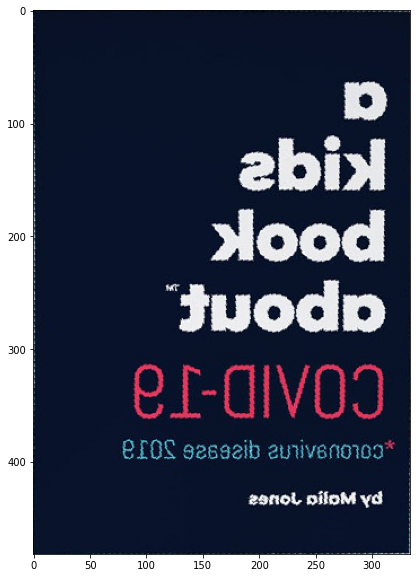

In [103]:
homo_img_kernel_op = d_homo_img_kernel.copy_to_host()
plt.figure(figsize = (20,10))
plt.imshow(homo_img_kernel_op);

In [104]:
%%writefile parallel_opt1.py
import numpy as np
from numba import *
from PIL import *
import requests
from io import BytesIO
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
import math
import time
from numba import jit, cuda
from PIL import Image

import sys

from itertools import permutations
import pandas as pd

from skimage.filters import threshold_local

# from google.colab.patches import cv2_imshow
# import imutils

import warnings
warnings.filterwarnings('ignore')

# if len(sys.argv) == 8:
#     img_path = sys.argv[1]
#     block_size = (int(sys.argv[2]), int(sys.argv[2]))
#     gau_kernel_size = int(sys.argv[3])
#     min_thres = float(sys.argv[4])
#     max_thres = float(sys.argv[5])
#     alpha = float(sys.argv[6])
#     beta = float(sys.argv[7])
# else:
#     img_path = '../input/image-test/poster.png'
#     block_size = (32,32)
#     gau_kernel_size = 3
#     min_thres = 0.05
#     max_thres = 0.15
#     alpha = 1.5
#     beta = 3

img_path = '../input/image-test/kid.png'
block_size = (32,32)
gau_kernel_size = 3
min_thres = 0.05
max_thres = 0.15
alpha = 1.5
beta = 3

img = np.asarray(Image.open(img_path))

gau_kernel = cv2.getGaussianKernel(gau_kernel_size**2,1)
gau_kernel = gau_kernel.reshape((gau_kernel_size,gau_kernel_size))
# gau_kernel = np.flip(gau_kernel)

sobel_x_kernel, sobel_y_kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], np.float32), np.array([[1,2,1],[0,0,0],[-1,-2,-1]], np.float32)

# sobel_x_kernel, sobel_y_kernel = np.flip(sobel_x_kernel), np.flip(sobel_y_kernel)


def get_pos (lst_can, min, max, pos = 0):
    if len(lst_can[(lst_can[:,pos] == min) | (lst_can[:,pos] == max)]) == 0:
        ans1 = lst_can[lst_can[:,pos] == lst_can[:,pos].max()]
        return ans1[0], -1
    else:
        if  len(lst_can[(lst_can[:,pos] == min) | (lst_can[:,pos] == max)]) == 2:
            ans1 = lst_can[(lst_can[:,pos] == min)]
            ans2 = lst_can[(lst_can[:,pos] == max)]
            return ans1[0], ans2[0]
        else:
            if  len(lst_can[(lst_can[:,pos] == max)]) == 1:
                ans2 = lst_can[(lst_can[:,pos] == max)]
                return ans2[0], -1
            else:
                ans2 = lst_can[(lst_can[:,pos] == min)]
                return ans2[0], -1

def get_points(xy, lst):
    if xy[1] == -1:
        lst.append(xy[0])
    else:
        lst.extend(xy)

def get_4_vertices(t, l, r, b, lst_v):
    lst = []

    get_points(list(t), lst)
    get_points(list(l), lst)
    get_points(list(r), lst)
    get_points(list(b), lst)

    for i in range(len(lst)):
        flag = False
        for j in range(len(lst_v)):
            comp = lst[i] == lst_v[j]
            if comp.any():
                flag = True
        if not flag:
            lst_v.append(lst[i])

def order_points_py(pts, max_x, max_y, min_x, min_y):
    lst = [i for i in range(len(pts))]
    pts_permutations = set(permutations(lst))
    for i in pts_permutations:
        t1, t2, s1, s2 = pts[i[0]], pts[i[1]], pts[i[2]], pts[i[3]]
        A = np.array([[t1[0], 1], 
                    [t2[0], 1]])
        y = np.array([t1[1], t2[1]])

        x1 = np.linalg.solve(A, y)

        A = np.array([[s1[0], 1], 
                    [s2[0], 1]])
        y = np.array([s1[1], s2[1]])

        x2 = np.linalg.solve(A, y)

        x  = (x2[1] - x1[1]) / (x1[0] - x2[0])
        x = x if min_x < x < max_x else -1

        y = x1[0] * x + x1[1]
        y = y if min_y < y < max_y else -1

        if x != -1 and y != -1:
            return np.array([t1, s1, t2, s2]) #tl, tr, br, bl

@cuda.jit
def convert_RGB_Gray_kernel(img_in, img_out):
    c,r = cuda.grid(2)
    if r < img_in.shape[0] and c < img_in.shape[1]:
        img_out[r,c] =  img_in[r,c,0] * 0.2989  + img_in[r,c,1] * 0.5870 + img_in[r,c,2] * 0.1141

@cuda.jit
def convolutionLayer_kernel(img_in, img_out, kernel):
    c,r = cuda.grid(2)
    if r < img_in.shape[0] and c < img_in.shape[1]:
        result = 0
        for i in range(kernel.shape[0]):
            for j in range(kernel.shape[1]):
                in_r = r - kernel.shape[0]//2 + i;
                in_c = c - kernel.shape[1]//2 + j;
                in_r = min(max(0, in_r), img_in.shape[0] - 1);
                in_c = min(max(0, in_c), img_in.shape[1] - 1);
                result += kernel[i,j] * img_in[in_r,in_c];
        img_out[r,c] = result

@cuda.jit
def convolutionLayer_kernel(img_in, img_out, kernel):
    c,r = cuda.grid(2)
    if r < img_in.shape[0] and c < img_in.shape[1]:
        result = 0
        for i in range(kernel.shape[0]):
            for j in range(kernel.shape[1]):
                in_r = r - kernel.shape[0]//2 + i;
                in_c = c - kernel.shape[1]//2 + j;
                in_r = min(max(0, in_r), img_in.shape[0] - 1);
                in_c = min(max(0, in_c), img_in.shape[1] - 1);
                result += kernel[i,j] * img_in[in_r,in_c];
        img_out[r,c] = result

@cuda.jit
def gradient_kernel(img_in, img_out, angle, kernel_x, kernel_y):
    c,r = cuda.grid(2)
    if r < img_in.shape[0] and c < img_in.shape[1]:
        result_x = 0
        result_y = 0
        for i in range(kernel_x.shape[0]):
            for j in range(kernel_x.shape[1]):
                in_r = r - kernel_x.shape[0]//2 + i;
                in_c = c - kernel_x.shape[1]//2 + j;
                in_r = min(max(0, in_r), img_in.shape[0] - 1);
                in_c = min(max(0, in_c), img_in.shape[1] - 1);
                result_x += kernel_x[i,j] * img_in[in_r,in_c];
                result_y += kernel_y[i,j] * img_in[in_r,in_c];
        img_out[r,c] = ((result_x ** 2) + (result_y ** 2)) ** 0.5
        angle[r,c] = math.atan2(result_y, result_x) * (180 / np.pi) 
        angle[r,c] = angle[r,c] if angle[r,c] >= 0 else angle[r,c]+180 

@cuda.jit
def nonMaxSuppression_kernel(img_in, img_out, angle):
    c,r = cuda.grid(2)
    if 0 < r < img_in.shape[0] - 1 and 0 < c < img_in.shape[1]-1:
        q, t = 255, 255
        if 0 <= angle[r,c] < 22.5 or 180 >= angle[r,c] >= 157.5:
            q, t = img_in[r, c+1], img_in[r, c-1]
        elif 67.5 > angle[r,c] >= 22.5:
            q, t = img_in[r+1, c-1], img_in[r-1, c+1]
        elif 112.5 > angle[r,c] >= 67.5:
            q, t = img_in[r+1, c], img_in[r-1, c]
        elif 157.5 > angle[r,c] >= 112.5:
            q, t = img_in[r-1, c-1], img_in[r+1, c+1]

        if img_in[r,c] >=q and img_in[r,c] >=t:
            img_out[r,c] = img_in[r,c]
        else:
            img_out[r,c] = 0
    elif r < img_in.shape[0] and c < img_in.shape[1]:
        img_out[r,c] = 0
        

@cuda.jit
def hysteresisThreshold_kernel(img_in,img_out, min_val, max_val):
    c, r = cuda.grid(2)
    if r < img_in.shape[0] and c < img_in.shape[1]:
        if img_in[r,c] > max_val:
            img_out[r,c] = 255
        elif img_in[r,c] > min_val:
            is_edge = False
            for i in range(max(0, r-1), min(img_in.shape[0], r+2)):
                for j in range(max(0, c-1), min(img_in.shape[1], c+2)):
                    if img_in[i,j] > max_val:
                        is_edge = True
                        img_out[r,c] = 255
                        break
                if is_edge:
                    break
        else:
            img_out[r,c] = 0

@cuda.jit
def map_homo_kernel(img_in, img_out, H):
    c,r = cuda.grid(2)
    if r < img_out.shape[0] and c < img_out.shape[0]:
        x = (H[0,0] * c + H[0,1] * r + H[0,2]) / (H[2,0] * c + H[2,1] * r + H[2,2])
        y = (H[1,0] * c + H[1,1] * r + H[1,2]) / (H[2,0] * c + H[2,1] * r + H[2,2])
        x = int(x) + 1 if (x*100) % 100 > 50 else int(x)
        y = int(y) + 1 if (y*100) % 100 > 50 else int(y)
        if 0 <= y < img_in.shape[0] and 0 <= x < img_in.shape[1]:
            img_out[r, c, 0], img_out[r, c, 1], img_out[r, c, 2] = img_in[y, x, 0], img_in[y, x, 1], img_in[y, x, 2]
                        
def controller(img, brightness=255, contrast=127):
    brightness = int((brightness - 0) * (255 - (-255)) / (510 - 0) + (-255))
    contrast = int((contrast - 0) * (127 - (-127)) / (254 - 0) + (-127))
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            max = 255
        else:
            shadow = 0
            max = 255 + brightness

        al_pha = (max - shadow) / 255
        ga_mma = shadow

        # The function addWeighted calculates
        # the weighted sum of two arrays
        cal = cv2.addWeighted(img, al_pha,img, 0, ga_mma)
    else:
        cal = img

    if contrast != 0:
        Alpha = float(131 * (contrast + 127)) / (127 * (131 - contrast))
        Gamma = 127 * (1 - Alpha)

        # The function addWeighted calculates
        # the weighted sum of two arrays
        cal = cv2.addWeighted(cal, Alpha,cal, 0, Gamma)
    return cal
s = time.time()
d_img = cuda.to_device(img)
d_gray_kernel = cuda.to_device(np.zeros((d_img.shape[0], d_img.shape[1])))

grid_size = (math.ceil(d_gray_kernel.shape[1] / block_size[0]), #chieu x
             math.ceil(d_gray_kernel.shape[0] / block_size[1])) #chieu y


convert_RGB_Gray_kernel[grid_size, block_size](d_img, d_gray_kernel)

d_conv = cuda.to_device(np.zeros(d_gray_kernel.shape))
d_gau_kernel = cuda.to_device(gau_kernel)

grid_size = (math.ceil(d_conv.shape[1] / block_size[0]), #chieu x
             math.ceil(d_conv.shape[0] / block_size[1])) #chieu y


convolutionLayer_kernel[grid_size, block_size](d_gray_kernel, d_conv, d_gau_kernel)

d_edge_gradient = cuda.to_device(np.zeros(d_gray_kernel.shape))
d_angle_kernel = cuda.to_device(np.zeros(d_gray_kernel.shape))
d_sobel_x_kernel, d_sobel_y_kernel = cuda.to_device(sobel_x_kernel), cuda.to_device(sobel_y_kernel)

grid_size = (math.ceil(d_edge_gradient.shape[1] / block_size[0]), #chieu x
             math.ceil(d_edge_gradient.shape[0] / block_size[1])) #chieu y

gradient_kernel[grid_size, block_size](d_conv, d_edge_gradient, d_angle_kernel, d_sobel_x_kernel, d_sobel_y_kernel)


d_non_max_kernel = cuda.to_device(np.zeros(d_edge_gradient.shape))

grid_size = (math.ceil(d_edge_gradient.shape[1] / block_size[0]), #chieu x
             math.ceil(d_edge_gradient.shape[0] / block_size[1])) #chieu y

nonMaxSuppression_kernel[grid_size, block_size](d_edge_gradient, d_non_max_kernel, d_angle_kernel)


non_max_kernel_op = d_non_max_kernel.copy_to_host()
max_val = non_max_kernel_op.max()


min_thres = 0.05
max_thres = 0.15

max_val = max_val * max_thres
min_val = max_val * min_thres

d_canny_edge_kernel = cuda.to_device(np.zeros(d_non_max_kernel.shape, np.uint8))

grid_size = (math.ceil(d_non_max_kernel.shape[1] / block_size[0]), #chieu x
             math.ceil(d_non_max_kernel.shape[0] / block_size[1])) #chieu y

hysteresisThreshold_kernel[grid_size, block_size](d_non_max_kernel, d_canny_edge_kernel, min_val, max_val)

canny_edge_kernel_op = d_canny_edge_kernel.copy_to_host()

cnts_kernel, _ = cv2.findContours(canny_edge_kernel_op.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts_kernel = sorted(cnts_kernel, key = lambda x:cv2.arcLength(x,True), reverse = True)

choosen_cnt = cnts_kernel[0].squeeze()

max_x, max_y = choosen_cnt[:,0].max(),choosen_cnt[:,1].max()
min_x, min_y = choosen_cnt[:,0].min(), choosen_cnt[:,1].min()

b_can, t_can = choosen_cnt[choosen_cnt[:,0] == max_x], choosen_cnt[choosen_cnt[:,0] == min_x]
l_can, r_can = choosen_cnt[choosen_cnt[:,1] == min_y], choosen_cnt[choosen_cnt[:,1] == max_y]

t, b = get_pos(t_can, min_y, max_y, 1), get_pos(b_can, min_y, max_y, 1)
l, r = get_pos(l_can, min_x, max_x, 0), get_pos(r_can, min_x, max_x, 0)

four_vertices_cnts_kernel = []

get_4_vertices(t, l, r, b, four_vertices_cnts_kernel)
four_vertices_cnts_kernel = order_points_py(four_vertices_cnts_kernel, max_x, max_y, min_x, min_y)

tl, tr, br, bl = four_vertices_cnts_kernel

widthA = ((br[0] - bl[0]) ** 2 + (br[1] - bl[1]) ** 2) ** 0.5
widthB = ((tr[0] - tl[0]) ** 2 + (tr[1] - tl[1]) ** 2) ** 0.5

maxWidth = int(widthA) if int(widthA) > int(widthB) else int(widthB)

heightA = ((tr[0] - br[0]) ** 2 + (tr[1] - br[1]) ** 2) ** 0.5
heightB = ((tl[0] - bl[0]) ** 2 + (tl[1] - bl[1]) ** 2) ** 0.5

maxHeight = int(heightA) if int(heightA) > int(heightB) else int(heightB)

n_four_vertices_cnts_kernel = [n_tl, n_tr, n_br, n_bl] = np.array([[0,0], 
                                                   [0, maxWidth-1], 
                                                   [maxHeight-1, maxWidth - 1], 
                                                   [maxHeight - 1, 0]], dtype = 'float32')

H = np.linalg.inv(cv2.getPerspectiveTransform(four_vertices_cnts_kernel.astype('float32'), n_four_vertices_cnts_kernel))


d_homo_img_kernel = cuda.to_device(np.zeros((maxWidth, maxHeight, img.shape[-1]), img.dtype))
d_H = cuda.to_device(H)

grid_size = (math.ceil(maxHeight / block_size[0]), #chieu x
             math.ceil(maxWidth / block_size[1])) #chieu y

map_homo_kernel[grid_size, block_size](d_img, d_homo_img_kernel, d_H)
map_homo_kernel[grid_size, block_size](d_img, d_homo_img_kernel, d_H)

homo_img_kernel_op = d_homo_img_kernel.copy_to_host()

brightness = 255#int(input('* Enter the brightness value [0-510]: '))
contrast = 170#float(input('* Enter the contrast value [0-254]: '))

in_adjust = homo_img_kernel_op.copy()
new_image_jit = controller(in_adjust, brightness, contrast)

print()
print()
print(time.time() - s)
print()
print()

Writing parallel_opt1.py


In [105]:
!nvprof --print-gpu-trace python parallel_opt1.py 

==114== NVPROF is profiling process 114, command: python parallel_opt1.py


2.2768192291259766


==114== Profiling application: python parallel_opt1.py
==114== Profiling result:
   Start  Duration            Grid Size      Block Size     Regs*    SSMem*    DSMem*      Size  Throughput  SrcMemType  DstMemType           Device   Context    Stream  Name
479.13ms  320.80us                    -               -         -         -         -  2.1629MB  6.5843GB/s    Pageable      Device  Tesla P100-PCIE         1         7  [CUDA memcpy HtoD]
480.64ms  2.4309ms                    -               -         -         -         -  5.7678MB  2.3171GB/s    Pageable      Device  Tesla P100-PCIE         1         7  [CUDA memcpy HtoD]
896.71ms  24.800us            (38 20 1)       (32 32 1)        21        0B        0B         -           -           -           -  Tesla P100-PCIE         1         7  _ZN6cudapy8__main__27convert_RGB_Gray_kernel_241B96cw51cXTLSUwv1kAPW1tQPAP9CY9GJAHUqIFJIBltW60OjnB1

* **Nhận xét**

So với thời gian chạy song song ở phiên bản trước thì khi copy dữ liệu qua GPU sẵn thì tốc độ được cải thiện, 2.4s so với 2.9s